In [ ]:
import pickle
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
import random
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

!pip install transformers
from transformers import BertTokenizer, BertConfig, BertForPreTraining
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Jul 19 15:02:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
torch.cuda.is_available()

True

# **Modul & Fungsi**

## Modul Multi Label Classification (BERT)

In [ ]:
import logging
import math

from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss

from transformers import AlbertPreTrainedModel, BertPreTrainedModel, AlbertModel, BertModel, BertConfig, XLMPreTrainedModel, XLMModel, XLMConfig, XLMRobertaModel, XLMRobertaConfig
from transformers import AutoTokenizer, AutoConfig

class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels_list

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifiers = nn.ModuleList([nn.Linear(config.hidden_size, num_label) for num_label in self.num_labels])

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        subword_to_word_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`, defaults to :obj:`None`):
            Labels for computing the token classification loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.

    Returns:
        :obj:`tuple(torch.FloatTensor)` comprising various elements depending on the configuration (:class:`~transformers.BertConfig`) and inputs:
        loss (:obj:`torch.FloatTensor` of shape :obj:`(1,)`, `optional`, returned when ``labels`` is provided) :
            Classification loss.
        scores (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, config.num_labels)`)
            Classification scores (before SoftMax).
        hidden_states (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_hidden_states=True``):
            Tuple of :obj:`torch.FloatTensor` (one for the output of the embeddings + one for the output of each layer)
            of shape :obj:`(batch_size, sequence_length, hidden_size)`.

            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        attentions (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_attentions=True``):
            Tuple of :obj:`torch.FloatTensor` (one for each layer) of shape
            :obj:`(batch_size, num_heads, sequence_length, sequence_length)`.

            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
        """

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output = self.dropout(outputs[1])
        logits = []
        for classifier in self.classifiers:
            logit = classifier(sequence_output)
            logits.append(logit)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            total_loss = 0
            for i, (logit, num_label) in enumerate(zip(logits, self.num_labels)):
                label = labels[:,i]
                loss = loss_fct(logit.view(-1, num_label), label.view(-1))
                total_loss += loss
            outputs = (total_loss,) + outputs

        return outputs  # (loss), scores, (hidden_states), (attentions)

if __name__ == '__main__':
    x = torch.LongTensor([[301,302,303,304]])
    y = torch.LongTensor([[0,1,0,1]])

    print("BertForMultiLabelClassification")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    config = AutoConfig.from_pretrained("bert-base-uncased")
    config.num_labels_list = [4,4,4,4]
    model = BertForMultiLabelClassification.from_pretrained("bert-base-uncased", config=config)
    output = model(x, labels=y)
    print(output[0], output[1])


BertForMultiLabelClassification


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForMultiLabelClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifiers.0.bias', 'classifiers.0.weight', 'classifiers.1.bias', 'classifiers.1.weight', 'classifiers.2.bias', 'classifiers.2.weight', 'classifiers.3.bias', 'classifiers.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor(5.2375, grad_fn=<AddBackward0>) [tensor([[ 0.0838,  0.1556,  0.2614, -0.4384]], grad_fn=<AddmmBackward0>), tensor([[-0.3286,  0.5853,  0.0076,  0.0978]], grad_fn=<AddmmBackward0>), tensor([[-0.0014, -0.0322, -0.3141, -0.2532]], grad_fn=<AddmmBackward0>), tensor([[ 0.1867, -0.4239,  0.0060, -0.3663]], grad_fn=<AddmmBackward0>)]


## Fungsi Forward

In [ ]:
# Forward function for sequence multilabel classification
def forward_sequence_multi_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data

    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)

    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2] # logits list<tensor(bs, num_label)> ~ list of batch prediction per class

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = [torch.topk(logit, 1)[1] for logit in logits] # list<tensor(bs)>
    batch_size = label_batch.shape[0]
    num_label = len(hyp)
    for i in range(batch_size):
        hyps = []
        labels = label_batch[i,:].cpu().numpy().tolist()
        for j in range(num_label):
            hyps.append(hyp[j][i].item())
        list_hyp.append([i2w[hyp] for hyp in hyps])
        list_label.append([i2w[label] for label in labels])

    return loss, list_hyp, list_label

## Fungsi Conlleval

In [ ]:
import re
from collections import defaultdict, namedtuple

Metrics = namedtuple('Metrics', 'tp fp fn prec rec fscore')

class EvalCounts(object):
    def __init__(self):
        self.correct_chunk = 0    # number of correctly identified chunks
        self.correct_tags = 0     # number of correct chunk tags
        self.found_correct = 0    # number of chunks in corpus
        self.found_guessed = 0    # number of identified chunks
        self.token_counter = 0    # token counter (ignores sentence breaks)

        # counts by type
        self.t_correct_chunk = defaultdict(int)
        self.t_found_correct = defaultdict(int)
        self.t_found_guessed = defaultdict(int)

###
# Evaluate Function
###
def parse_tag(t):
    m = re.match(r'^([^-]*)-(.*)$', t)
    return m.groups() if m else (t, '')

def start_of_chunk(prev_tag, tag, prev_type, type_):
    # check if a chunk started between the previous and current word
    # arguments: previous and current chunk tags, previous and current types
    chunk_start = False

    if tag == 'B': chunk_start = True
    if tag == 'S': chunk_start = True

    if prev_tag == 'E' and tag == 'E': chunk_start = True
    if prev_tag == 'E' and tag == 'I': chunk_start = True
    if prev_tag == 'S' and tag == 'E': chunk_start = True
    if prev_tag == 'S' and tag == 'I': chunk_start = True
    if prev_tag == 'O' and tag == 'E': chunk_start = True
    if prev_tag == 'O' and tag == 'I': chunk_start = True

    if tag != 'O' and tag != '.' and prev_type != type_:
        chunk_start = True

    # these chunks are assumed to have length 1
    if tag == '[': chunk_start = True
    if tag == ']': chunk_start = True

    return chunk_start

def end_of_chunk(prev_tag, tag, prev_type, type_):
    # check if a chunk ended between the previous and current word
    # arguments: previous and current chunk tags, previous and current types
    chunk_end = False

    if prev_tag == 'E': chunk_end = True
    if prev_tag == 'S': chunk_end = True

    if prev_tag == 'B' and tag == 'B': chunk_end = True
    if prev_tag == 'B' and tag == 'S': chunk_end = True
    if prev_tag == 'B' and tag == 'O': chunk_end = True
    if prev_tag == 'I' and tag == 'B': chunk_end = True
    if prev_tag == 'I' and tag == 'S': chunk_end = True
    if prev_tag == 'I' and tag == 'O': chunk_end = True

    if prev_tag != 'O' and prev_tag != '.' and prev_type != type_:
        chunk_end = True

    # these chunks are assumed to have length 1
    if prev_tag == ']': chunk_end = True
    if prev_tag == '[': chunk_end = True

    return chunk_end

def evaluate_fn(guessed, correct, last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts):
    guessed, guessed_type = parse_tag(guessed)
    correct, correct_type = parse_tag(correct)

    end_correct = end_of_chunk(last_correct, correct,
                               last_correct_type, correct_type)
    end_guessed = end_of_chunk(last_guessed, guessed,
                               last_guessed_type, guessed_type)
    start_correct = start_of_chunk(last_correct, correct,
                                   last_correct_type, correct_type)
    start_guessed = start_of_chunk(last_guessed, guessed,
                                   last_guessed_type, guessed_type)

    if in_correct:
        if (end_correct and end_guessed and
            last_guessed_type == last_correct_type):
            in_correct = False
            counts.correct_chunk += 1
            counts.t_correct_chunk[last_correct_type] += 1
        elif (end_correct != end_guessed or guessed_type != correct_type):
            in_correct = False

    if start_correct and start_guessed and guessed_type == correct_type:
        in_correct = True

    if start_correct:
        counts.found_correct += 1
        counts.t_found_correct[correct_type] += 1
    if start_guessed:
        counts.found_guessed += 1
        counts.t_found_guessed[guessed_type] += 1
    if correct == guessed and guessed_type == correct_type:
        counts.correct_tags += 1
    counts.token_counter += 1

    last_guessed = guessed
    last_correct = correct
    last_guessed_type = guessed_type
    last_correct_type = correct_type

    return last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts

def evaluate(hyps_list, labels_list):
    counts = EvalCounts()
    num_features = None       # number of features per line
    in_correct = False        # currently processed chunks is correct until now
    last_correct = 'O'        # previous chunk tag in corpus
    last_correct_type = ''    # type of previously identified chunk tag
    last_guessed = 'O'        # previously identified chunk tag
    last_guessed_type = ''    # type of previous chunk tag in corpus

    for hyps, labels in zip(hyps_list, labels_list):
        for hyp, label in zip(hyps, labels):
            step_result = evaluate_fn(hyp, label, last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts)
            last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts = step_result
        # Boundary between sentence
        step_result = evaluate_fn('O', 'O', last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts)
        last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts = step_result

    if in_correct:
        counts.correct_chunk += 1
        counts.t_correct_chunk[last_correct_type] += 1

    return counts

###
# Calculate Metrics Function
###
def uniq(iterable):
    seen = set()
    return [i for i in iterable if not (i in seen or seen.add(i))]

def calculate_metrics(correct, guessed, total):
    tp, fp, fn = correct, guessed-correct, total-correct
    p = 0 if tp + fp == 0 else 1.*tp / (tp + fp)
    r = 0 if tp + fn == 0 else 1.*tp / (tp + fn)
    f = 0 if p + r == 0 else (2 * p * r) / (p + r)
    return Metrics(tp, fp, fn, p, r, f)

def metrics(counts):
    c = counts
    overall = calculate_metrics(
        c.correct_chunk, c.found_guessed, c.found_correct
    )
    by_type = {}
    for t in uniq(list(c.t_found_correct.keys()) + list(c.t_found_guessed.keys())):
        by_type[t] = calculate_metrics(
            c.t_correct_chunk[t], c.t_found_guessed[t], c.t_found_correct[t]
        )
    return overall, by_type
    return overall

###
# Main Function
###
def conll_evaluation(hyps_list, labels_list):
    counts = evaluate(hyps_list, labels_list)
    overall, by_type = metrics(counts)

    c = counts
    acc = c.correct_tags / c.token_counter
    pre = overall.prec
    rec = overall.rec
    f1 = overall.fscore

    type_macro_pre = 0.0
    type_macro_rec = 0.0
    type_macro_f1 = 0.0
    for k in by_type.keys():
        type_macro_pre += by_type[k].prec
        type_macro_rec += by_type[k].rec
        type_macro_f1 += by_type[k].fscore

    type_macro_pre = type_macro_pre / float(len(by_type))
    type_macro_rec = type_macro_rec / float(len(by_type))
    type_macro_f1 = type_macro_f1 / float(len(by_type))

    return (acc, pre, rec, f1, type_macro_pre, type_macro_rec, type_macro_f1)

## Fungsi Metrics

In [ ]:
import itertools
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def absa_metrics_fn(list_hyp, list_label):
    # hyp and label are both list (multi label), flatten the list
    list_hyp = list(itertools.chain.from_iterable(list_hyp))
    list_label = list(itertools.chain.from_iterable(list_label))

    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics

# Function to plot confusion matrix
def plot_confusion_matrix(cm, aspect, fold_idx):
    ax = sns.heatmap(cm, annot=True, fmt='g')
    ax.set_title(f"Confusion Matrix for {aspect} (Fold {fold_idx})")
    plt.show()

## Fungsi Data Utils

In [ ]:
import string
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

class AspectBasedSentimentAnalysisDataset(Dataset):
    # Static constant variable
    ASPECT_DOMAIN = [0, 1, 2, 3, 4, 5]
    LABEL2INDEX = {'none': 0, 'negatif': 1, 'netral': 2, 'positif': 3}
    INDEX2LABEL = {0: 'none', 1: 'negatif', 2: 'netral', 3: 'positif'}
    NUM_LABELS = [4, 4, 4, 4, 4, 4]
    NUM_ASPECTS = 6

    def change_type(self, labels):
        for aspect in self.ASPECT_DOMAIN:
            labels.loc[:, aspect] = labels.loc[:, aspect].apply(lambda x: self.LABEL2INDEX[x])
        return labels

    def __init__(self, texts, labels, tokenizer, no_special_token=False, *args, **kwargs):
        self.texts = texts
        self.labels = self.change_type(labels)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token

    def __getitem__(self, index):
        texts, labels = self.texts[index], self.labels.iloc[index].values
        subwords = self.tokenizer.encode(texts, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(labels), texts

    def __len__(self):
        return len(self.texts)


class AspectBasedSentimentAnalysisDataLoader(DataLoader):
    def __init__(self, dataset, max_seq_len=512, *args, **kwargs):
        super(AspectBasedSentimentAnalysisDataLoader, self).__init__(dataset=dataset, *args, **kwargs)
        self.num_aspects = dataset.NUM_ASPECTS
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len

    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)

        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        label_batch = np.zeros((batch_size, self.num_aspects), dtype=np.int64)

        seq_list = []

        for i, (subwords, label, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            label_batch[i,:] = label

            seq_list.append(raw_seq)

        return subword_batch, mask_batch, label_batch, seq_list

# Fungsi Umum

In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
# Set random seed
set_seed(26092020)

# Load Model

In [ ]:
# Load Tokenizer and Config
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # BERT
# config = BertConfig.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1') # IndoBERT
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')

# Config
config.num_labels = max(AspectBasedSentimentAnalysisDataset.NUM_LABELS)
config.num_labels_list = AspectBasedSentimentAnalysisDataset.NUM_LABELS

# Instantiate model
# model = BertForMultiLabelClassification.from_pretrained('bert-base-uncased', config=config) # BERT
model = BertForMultiLabelClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config) # IndoBERT

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForMultiLabelClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifiers.0.bias', 'classifiers.0.weight', 'classifiers.1.bias', 'classifiers.1.weight', 'classifiers.2.bias', 'classifiers.2.weight', 'classifiers.3.bias', 'classifiers.3.weight', 'classifiers.4.bias', 'classifiers.4.weight', 'classifiers.5.bias', 'classifiers.5.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
count_param(model)

124459800

# Prepare Dataset

In [ ]:
# Load Data
X = pickle.load(open('/content/drive/MyDrive/Skripsi/Library/text_s1.pkl', 'rb'))
y = pickle.load(open('/content/drive/MyDrive/Skripsi/Library/label_data.pkl', 'rb'))

# Fine Tuning & Evaluation

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)
model = model.cuda()

In [ ]:
w2i, i2w = AspectBasedSentimentAnalysisDataset.LABEL2INDEX, AspectBasedSentimentAnalysisDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'none': 0, 'negatif': 1, 'netral': 2, 'positif': 3}
{0: 'none', 1: 'negatif', 2: 'netral', 3: 'positif'}


(Epoch 1) TRAIN LOSS:3.1566 LR:0.00001000: 100%|██████████| 220/220 [00:31<00:00,  6.96it/s]


(Epoch 1) TRAIN LOSS:3.1566 ACC:0.82 F1:0.51 REC:0.50 PRE:0.55 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 30.96it/s]


(Epoch 1) VALID LOSS: 2.2930 ACC:0.88 F1:0.69 REC:0.66 PRE:0.75


(Epoch 2) TRAIN LOSS:1.9358 LR:0.00001000: 100%|██████████| 220/220 [00:22<00:00,  9.94it/s]


(Epoch 2) TRAIN LOSS:1.9358 ACC:0.90 F1:0.72 REC:0.70 PRE:0.76 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 27.82it/s]


(Epoch 2) VALID LOSS: 1.8636 ACC:0.90 F1:0.74 REC:0.71 PRE:0.79


(Epoch 3) TRAIN LOSS:1.4034 LR:0.00001000: 100%|██████████| 220/220 [00:22<00:00,  9.91it/s]


(Epoch 3) TRAIN LOSS:1.4034 ACC:0.93 F1:0.82 REC:0.80 PRE:0.84 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 38.69it/s]


(Epoch 3) VALID LOSS: 1.6664 ACC:0.91 F1:0.78 REC:0.77 PRE:0.81


(Epoch 4) TRAIN LOSS:1.0402 LR:0.00001000: 100%|██████████| 220/220 [00:22<00:00,  9.82it/s]


(Epoch 4) TRAIN LOSS:1.0402 ACC:0.95 F1:0.87 REC:0.86 PRE:0.89 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 39.51it/s]


(Epoch 4) VALID LOSS: 1.6419 ACC:0.91 F1:0.76 REC:0.74 PRE:0.80


(Epoch 5) TRAIN LOSS:0.7890 LR:0.00001000: 100%|██████████| 220/220 [00:25<00:00,  8.76it/s]


(Epoch 5) TRAIN LOSS:0.7890 ACC:0.97 F1:0.91 REC:0.90 PRE:0.93 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 39.45it/s]


(Epoch 5) VALID LOSS: 1.5736 ACC:0.91 F1:0.79 REC:0.79 PRE:0.80


(Epoch 6) TRAIN LOSS:0.6032 LR:0.00001000: 100%|██████████| 220/220 [00:22<00:00,  9.88it/s]


(Epoch 6) TRAIN LOSS:0.6032 ACC:0.98 F1:0.94 REC:0.93 PRE:0.95 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 30.28it/s]


(Epoch 6) VALID LOSS: 1.5914 ACC:0.91 F1:0.77 REC:0.76 PRE:0.80
Early stopping at epoch 6, loading best model from epoch 5


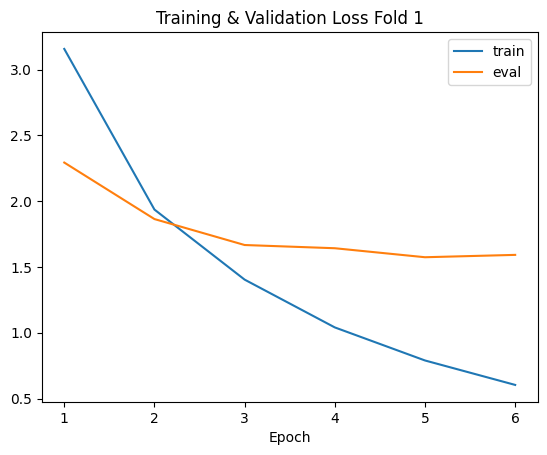

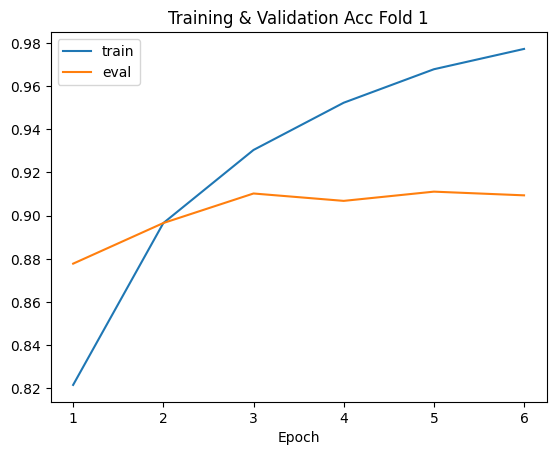

TEST LOSS:1.6947 ACC:0.91 F1:0.74 REC:0.73 PRE:0.74: 100%|██████████| 28/28 [00:01<00:00, 24.33it/s]


(Epoch 6) TEST LOSS:1.6947 ACC:0.91 F1:0.74 REC:0.73 PRE:0.74


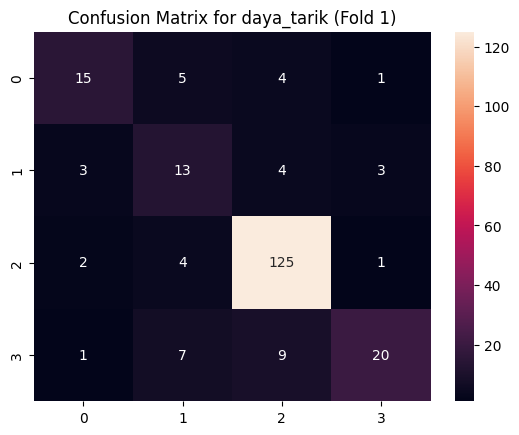

              precision    recall  f1-score   support

     negatif       0.71      0.60      0.65        25
      netral       0.45      0.57      0.50        23
        none       0.88      0.95      0.91       132
     positif       0.80      0.54      0.65        37

    accuracy                           0.80       217
   macro avg       0.71      0.66      0.68       217
weighted avg       0.80      0.80      0.79       217



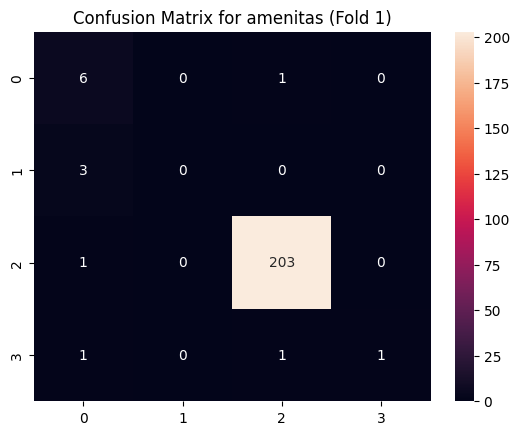

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     negatif       0.55      0.86      0.67         7
      netral       0.00      0.00      0.00         3
        none       0.99      1.00      0.99       204
     positif       1.00      0.33      0.50         3

    accuracy                           0.97       217
   macro avg       0.63      0.55      0.54       217
weighted avg       0.96      0.97      0.96       217



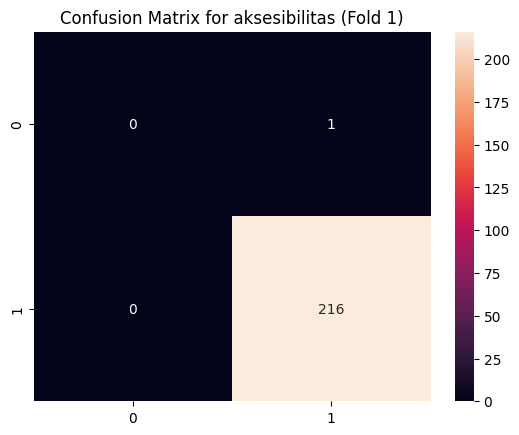

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00         1
        none       1.00      1.00      1.00       216

    accuracy                           1.00       217
   macro avg       0.50      0.50      0.50       217
weighted avg       0.99      1.00      0.99       217



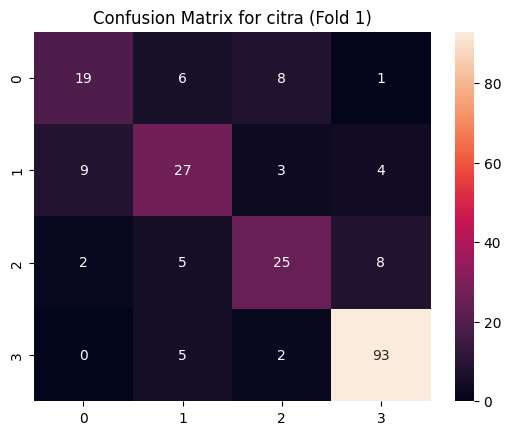

              precision    recall  f1-score   support

     negatif       0.63      0.56      0.59        34
      netral       0.63      0.63      0.63        43
        none       0.66      0.62      0.64        40
     positif       0.88      0.93      0.90       100

    accuracy                           0.76       217
   macro avg       0.70      0.69      0.69       217
weighted avg       0.75      0.76      0.75       217



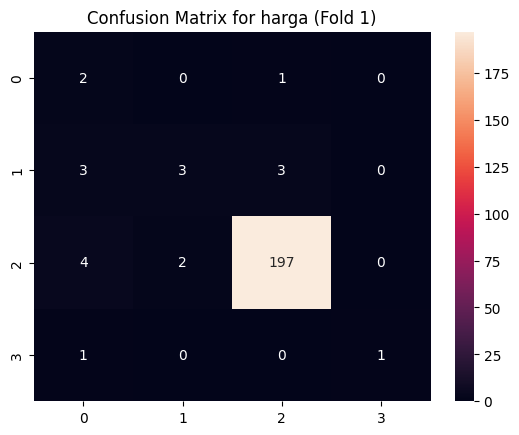

              precision    recall  f1-score   support

     negatif       0.20      0.67      0.31         3
      netral       0.60      0.33      0.43         9
        none       0.98      0.97      0.98       203
     positif       1.00      0.50      0.67         2

    accuracy                           0.94       217
   macro avg       0.70      0.62      0.59       217
weighted avg       0.95      0.94      0.94       217



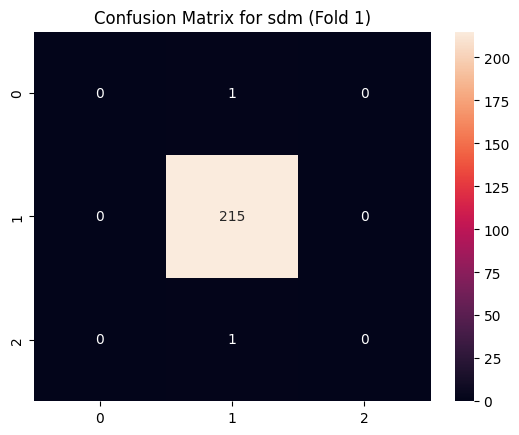

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00         1
        none       0.99      1.00      1.00       215
     positif       0.00      0.00      0.00         1

    accuracy                           0.99       217
   macro avg       0.33      0.33      0.33       217
weighted avg       0.98      0.99      0.99       217

Iteration time for fold 1: 171.36 seconds
Accuracy for fold 1: [0.797, 0.968, 0.995, 0.756, 0.935, 0.991]
F1 Score for fold 1: [0.793, 0.962, 0.993, 0.752, 0.941, 0.986]


(Epoch 1) TRAIN LOSS:0.7785 LR:0.00001000: 100%|██████████| 220/220 [00:21<00:00, 10.18it/s]


(Epoch 1) TRAIN LOSS:0.7785 ACC:0.97 F1:0.91 REC:0.90 PRE:0.92 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 35.38it/s]


(Epoch 1) VALID LOSS: 1.5298 ACC:0.91 F1:0.78 REC:0.76 PRE:0.81


(Epoch 2) TRAIN LOSS:0.5954 LR:0.00001000: 100%|██████████| 220/220 [00:23<00:00,  9.27it/s]


(Epoch 2) TRAIN LOSS:0.5954 ACC:0.98 F1:0.94 REC:0.93 PRE:0.95 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 39.52it/s]


(Epoch 2) VALID LOSS: 1.3962 ACC:0.92 F1:0.81 REC:0.80 PRE:0.82


(Epoch 3) TRAIN LOSS:0.4744 LR:0.00001000: 100%|██████████| 220/220 [00:23<00:00,  9.48it/s]


(Epoch 3) TRAIN LOSS:0.4744 ACC:0.98 F1:0.95 REC:0.95 PRE:0.96 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 40.35it/s]


(Epoch 3) VALID LOSS: 1.4897 ACC:0.92 F1:0.80 REC:0.79 PRE:0.82
Early stopping at epoch 3, loading best model from epoch 2


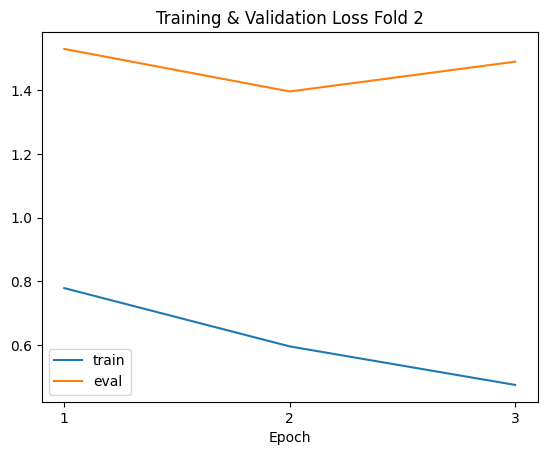

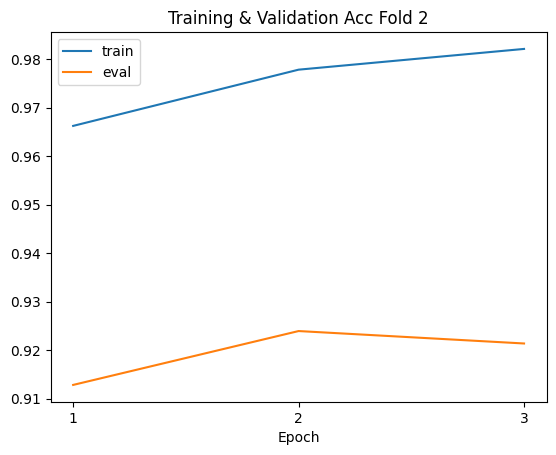

TEST LOSS:0.6239 ACC:0.98 F1:0.94 REC:0.93 PRE:0.95: 100%|██████████| 28/28 [00:01<00:00, 24.57it/s]


(Epoch 3) TEST LOSS:0.6239 ACC:0.98 F1:0.94 REC:0.93 PRE:0.95


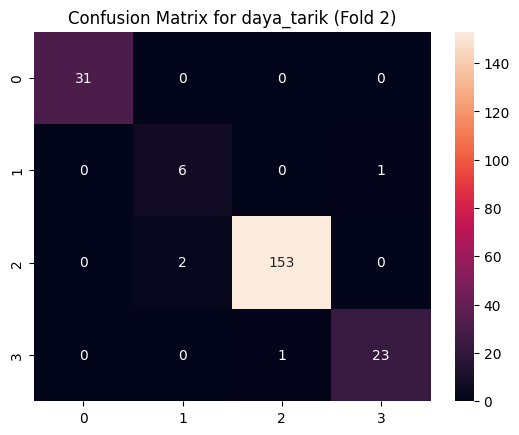

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00        31
      netral       0.75      0.86      0.80         7
        none       0.99      0.99      0.99       155
     positif       0.96      0.96      0.96        24

    accuracy                           0.98       217
   macro avg       0.93      0.95      0.94       217
weighted avg       0.98      0.98      0.98       217



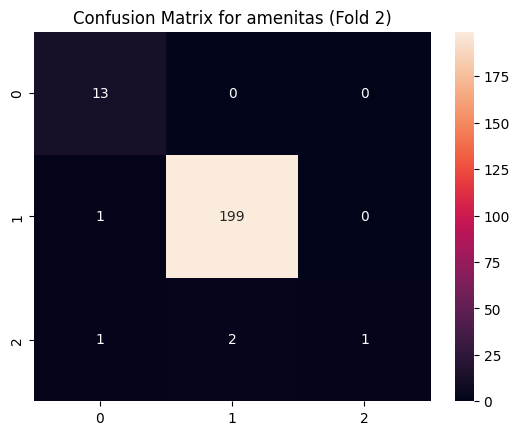

              precision    recall  f1-score   support

     negatif       0.87      1.00      0.93        13
        none       0.99      0.99      0.99       200
     positif       1.00      0.25      0.40         4

    accuracy                           0.98       217
   macro avg       0.95      0.75      0.77       217
weighted avg       0.98      0.98      0.98       217



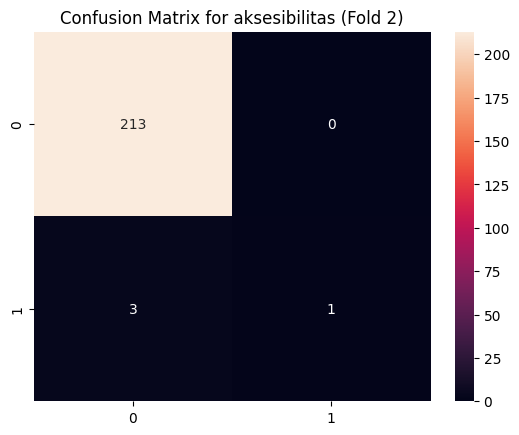

              precision    recall  f1-score   support

        none       0.99      1.00      0.99       213
     positif       1.00      0.25      0.40         4

    accuracy                           0.99       217
   macro avg       0.99      0.62      0.70       217
weighted avg       0.99      0.99      0.98       217



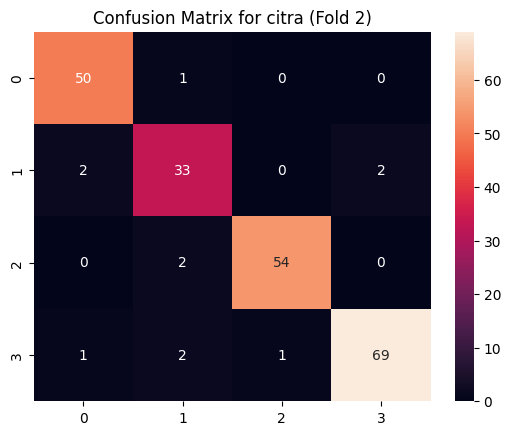

              precision    recall  f1-score   support

     negatif       0.94      0.98      0.96        51
      netral       0.87      0.89      0.88        37
        none       0.98      0.96      0.97        56
     positif       0.97      0.95      0.96        73

    accuracy                           0.95       217
   macro avg       0.94      0.95      0.94       217
weighted avg       0.95      0.95      0.95       217



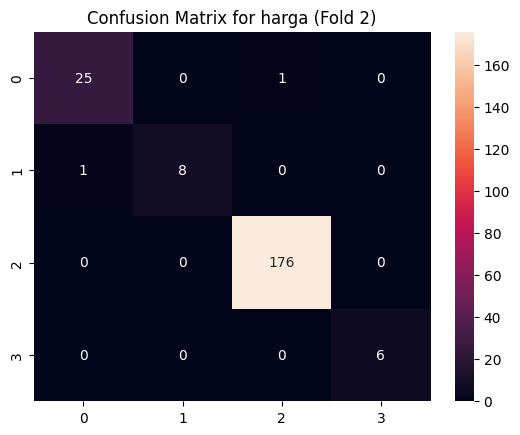

              precision    recall  f1-score   support

     negatif       0.96      0.96      0.96        26
      netral       1.00      0.89      0.94         9
        none       0.99      1.00      1.00       176
     positif       1.00      1.00      1.00         6

    accuracy                           0.99       217
   macro avg       0.99      0.96      0.97       217
weighted avg       0.99      0.99      0.99       217



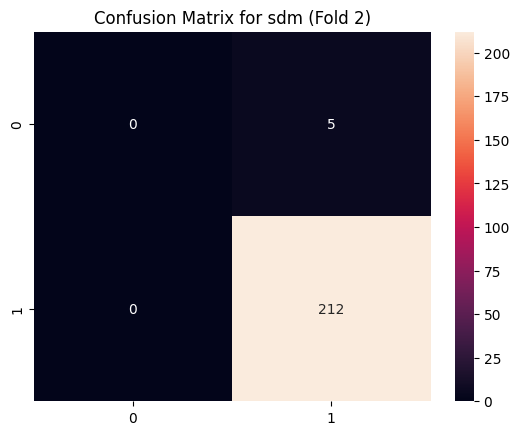

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00         5
        none       0.98      1.00      0.99       212

    accuracy                           0.98       217
   macro avg       0.49      0.50      0.49       217
weighted avg       0.95      0.98      0.97       217

Iteration time for fold 2: 79.78 seconds
Accuracy for fold 2: [0.982, 0.982, 0.986, 0.949, 0.991, 0.977]
F1 Score for fold 2: [0.982, 0.978, 0.982, 0.95, 0.991, 0.966]


(Epoch 1) TRAIN LOSS:0.4911 LR:0.00001000: 100%|██████████| 220/220 [00:22<00:00,  9.69it/s]


(Epoch 1) TRAIN LOSS:0.4911 ACC:0.98 F1:0.96 REC:0.95 PRE:0.96 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 33.02it/s]


(Epoch 1) VALID LOSS: 1.3105 ACC:0.93 F1:0.83 REC:0.80 PRE:0.86


(Epoch 2) TRAIN LOSS:0.3830 LR:0.00001000: 100%|██████████| 220/220 [00:23<00:00,  9.31it/s]


(Epoch 2) TRAIN LOSS:0.3830 ACC:0.99 F1:0.96 REC:0.96 PRE:0.97 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 28.68it/s]


(Epoch 2) VALID LOSS: 1.3958 ACC:0.93 F1:0.81 REC:0.80 PRE:0.84
Early stopping at epoch 2, loading best model from epoch 1


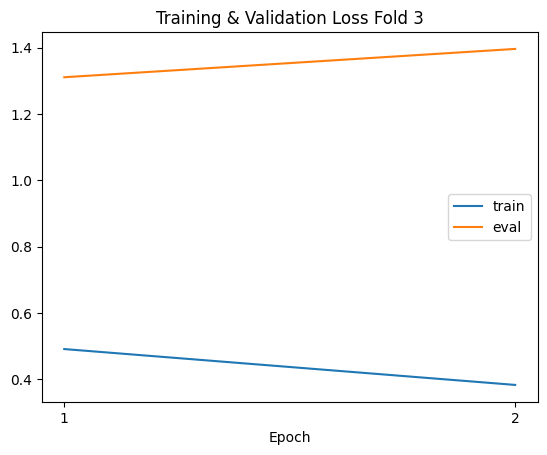

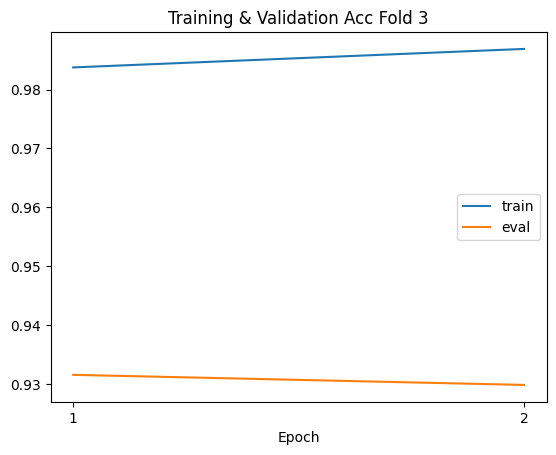

TEST LOSS:0.5860 ACC:0.97 F1:0.94 REC:0.93 PRE:0.95: 100%|██████████| 28/28 [00:01<00:00, 24.16it/s]


(Epoch 2) TEST LOSS:0.5860 ACC:0.97 F1:0.94 REC:0.93 PRE:0.95


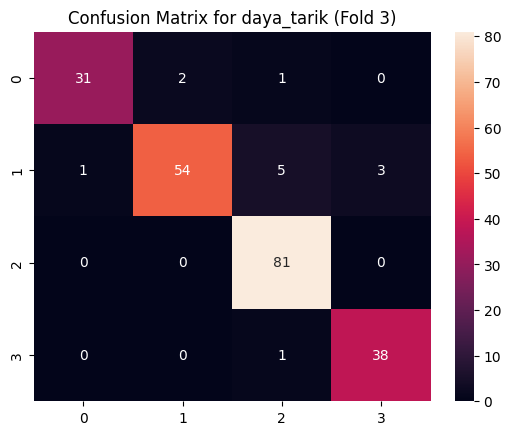

              precision    recall  f1-score   support

     negatif       0.97      0.91      0.94        34
      netral       0.96      0.86      0.91        63
        none       0.92      1.00      0.96        81
     positif       0.93      0.97      0.95        39

    accuracy                           0.94       217
   macro avg       0.95      0.94      0.94       217
weighted avg       0.94      0.94      0.94       217



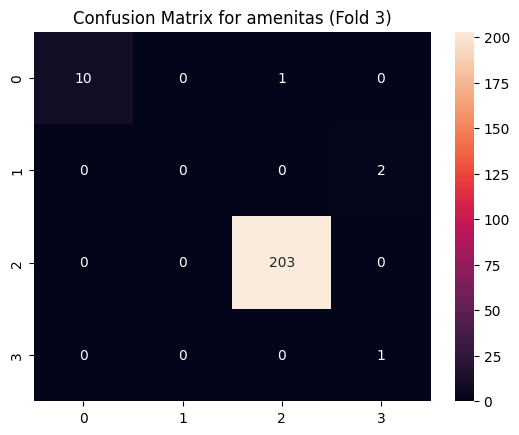

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     negatif       1.00      0.91      0.95        11
      netral       0.00      0.00      0.00         2
        none       1.00      1.00      1.00       203
     positif       0.33      1.00      0.50         1

    accuracy                           0.99       217
   macro avg       0.58      0.73      0.61       217
weighted avg       0.98      0.99      0.98       217



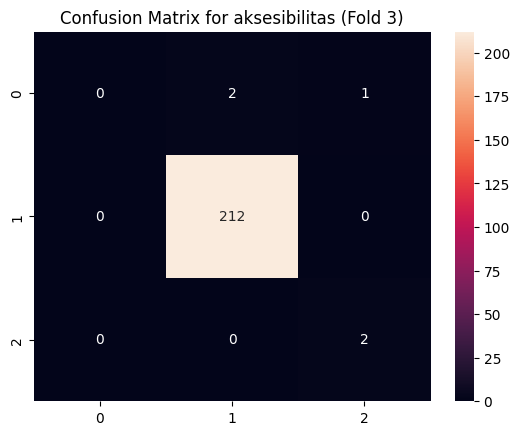

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00         3
        none       0.99      1.00      1.00       212
     positif       0.67      1.00      0.80         2

    accuracy                           0.99       217
   macro avg       0.55      0.67      0.60       217
weighted avg       0.97      0.99      0.98       217



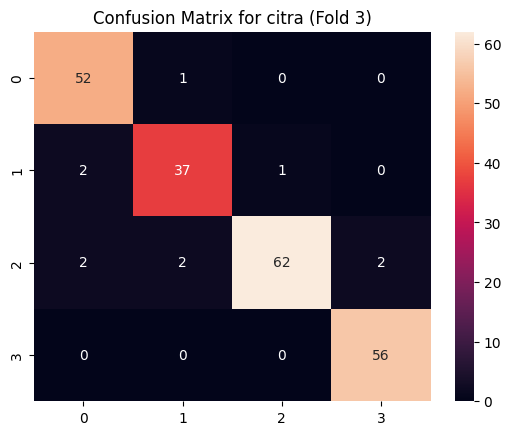

              precision    recall  f1-score   support

     negatif       0.93      0.98      0.95        53
      netral       0.93      0.93      0.93        40
        none       0.98      0.91      0.95        68
     positif       0.97      1.00      0.98        56

    accuracy                           0.95       217
   macro avg       0.95      0.95      0.95       217
weighted avg       0.95      0.95      0.95       217



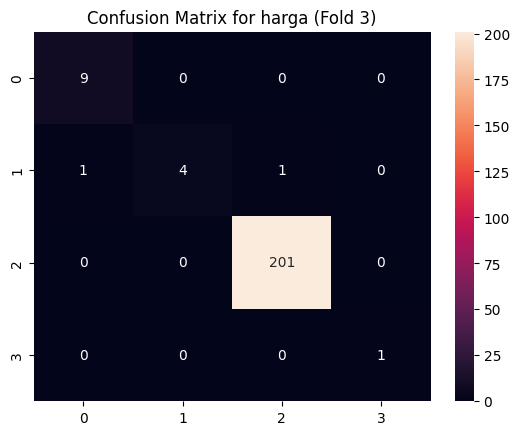

              precision    recall  f1-score   support

     negatif       0.90      1.00      0.95         9
      netral       1.00      0.67      0.80         6
        none       1.00      1.00      1.00       201
     positif       1.00      1.00      1.00         1

    accuracy                           0.99       217
   macro avg       0.97      0.92      0.94       217
weighted avg       0.99      0.99      0.99       217



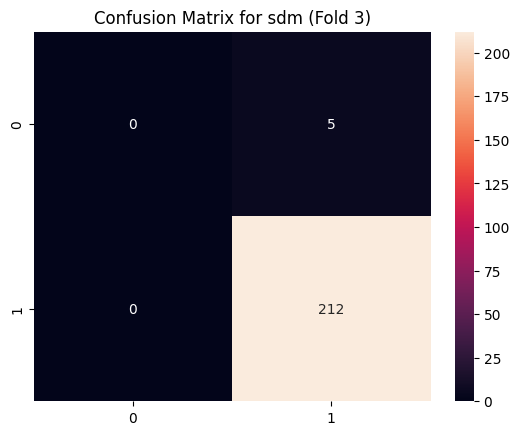

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00         5
        none       0.98      1.00      0.99       212

    accuracy                           0.98       217
   macro avg       0.49      0.50      0.49       217
weighted avg       0.95      0.98      0.97       217

Iteration time for fold 3: 55.46 seconds
Accuracy for fold 3: [0.94, 0.986, 0.986, 0.954, 0.991, 0.977]
F1 Score for fold 3: [0.939, 0.984, 0.98, 0.954, 0.99, 0.966]


(Epoch 1) TRAIN LOSS:0.4155 LR:0.00001000: 100%|██████████| 220/220 [00:22<00:00,  9.87it/s]


(Epoch 1) TRAIN LOSS:0.4155 ACC:0.98 F1:0.96 REC:0.95 PRE:0.97 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 30.55it/s]


(Epoch 1) VALID LOSS: 1.2371 ACC:0.94 F1:0.84 REC:0.83 PRE:0.84


(Epoch 2) TRAIN LOSS:0.3199 LR:0.00001000: 100%|██████████| 220/220 [00:23<00:00,  9.39it/s]


(Epoch 2) TRAIN LOSS:0.3199 ACC:0.99 F1:0.98 REC:0.97 PRE:0.98 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 38.05it/s]


(Epoch 2) VALID LOSS: 1.2104 ACC:0.94 F1:0.83 REC:0.82 PRE:0.84


(Epoch 3) TRAIN LOSS:0.2702 LR:0.00001000: 100%|██████████| 220/220 [00:24<00:00,  9.16it/s]


(Epoch 3) TRAIN LOSS:0.2702 ACC:0.99 F1:0.98 REC:0.98 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 40.95it/s]


(Epoch 3) VALID LOSS: 1.1794 ACC:0.94 F1:0.84 REC:0.84 PRE:0.85


(Epoch 4) TRAIN LOSS:0.2241 LR:0.00001000: 100%|██████████| 220/220 [00:24<00:00,  9.12it/s]


(Epoch 4) TRAIN LOSS:0.2241 ACC:0.99 F1:0.99 REC:0.98 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 39.01it/s]


(Epoch 4) VALID LOSS: 1.2526 ACC:0.94 F1:0.83 REC:0.82 PRE:0.85
Early stopping at epoch 4, loading best model from epoch 3


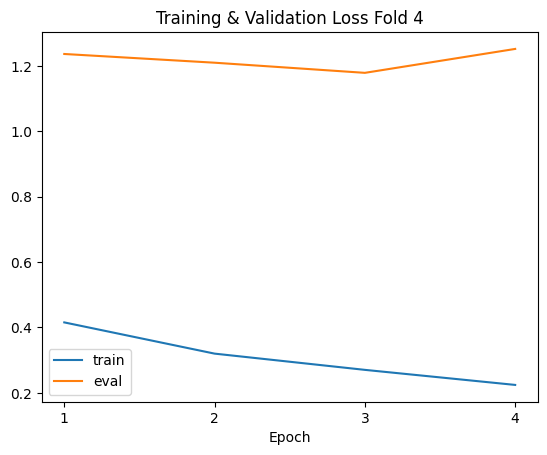

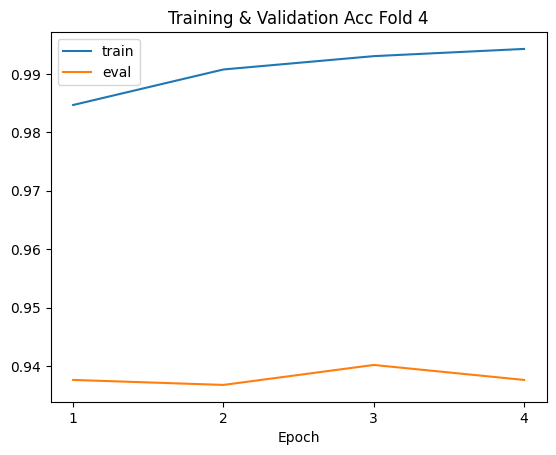

TEST LOSS:0.2350 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00:   4%|▎         | 1/28 [00:00<00:03,  8.31it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
TEST LOSS:0.3055 ACC:0.99 F1:0.95 REC:0.94 PRE:0.96: 100%|██████████| 28/28 [00:01<00:00, 23.35it/s]


(Epoch 4) TEST LOSS:0.3055 ACC:0.99 F1:0.95 REC:0.94 PRE:0.96


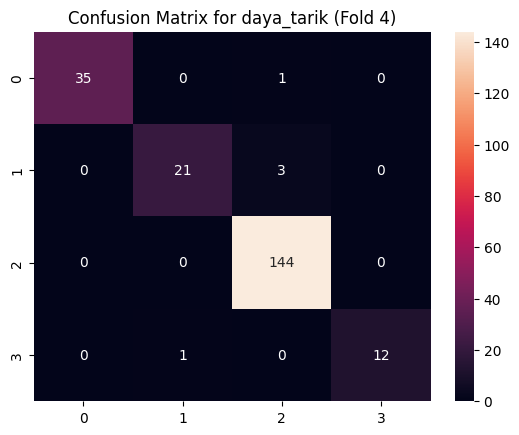

              precision    recall  f1-score   support

     negatif       1.00      0.97      0.99        36
      netral       0.95      0.88      0.91        24
        none       0.97      1.00      0.99       144
     positif       1.00      0.92      0.96        13

    accuracy                           0.98       217
   macro avg       0.98      0.94      0.96       217
weighted avg       0.98      0.98      0.98       217



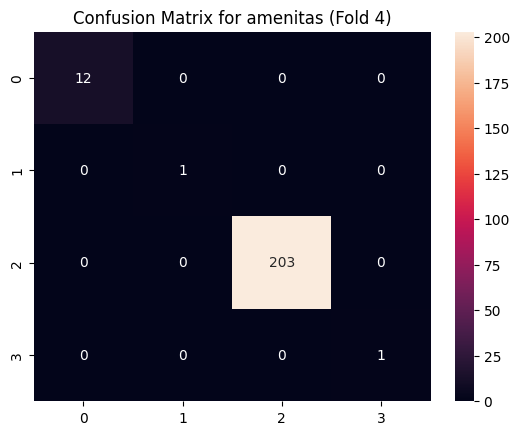

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00        12
      netral       1.00      1.00      1.00         1
        none       1.00      1.00      1.00       203
     positif       1.00      1.00      1.00         1

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217



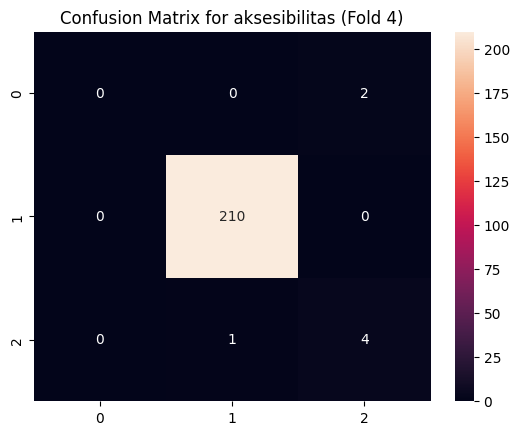

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      netral       0.00      0.00      0.00         2
        none       1.00      1.00      1.00       210
     positif       0.67      0.80      0.73         5

    accuracy                           0.99       217
   macro avg       0.55      0.60      0.57       217
weighted avg       0.98      0.99      0.98       217



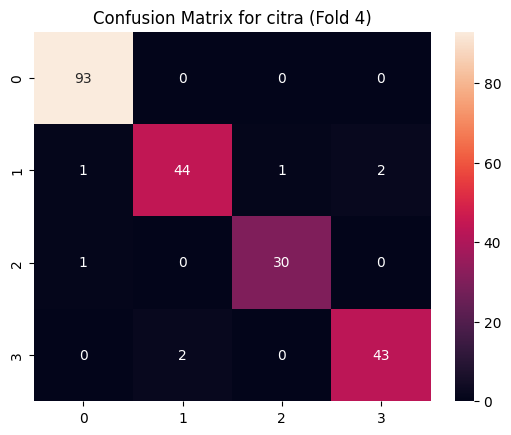

              precision    recall  f1-score   support

     negatif       0.98      1.00      0.99        93
      netral       0.96      0.92      0.94        48
        none       0.97      0.97      0.97        31
     positif       0.96      0.96      0.96        45

    accuracy                           0.97       217
   macro avg       0.96      0.96      0.96       217
weighted avg       0.97      0.97      0.97       217



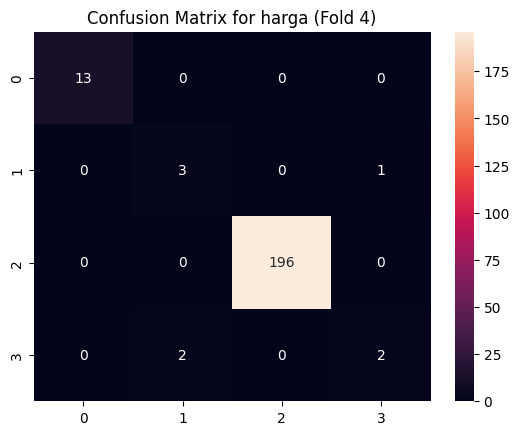

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00        13
      netral       0.60      0.75      0.67         4
        none       1.00      1.00      1.00       196
     positif       0.67      0.50      0.57         4

    accuracy                           0.99       217
   macro avg       0.82      0.81      0.81       217
weighted avg       0.99      0.99      0.99       217



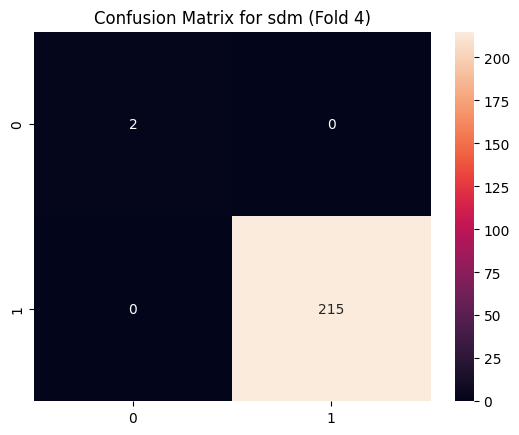

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00         2
        none       1.00      1.00      1.00       215

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217

Iteration time for fold 4: 107.85 seconds
Accuracy for fold 4: [0.977, 1.0, 0.986, 0.968, 0.986, 1.0]
F1 Score for fold 4: [0.977, 1.0, 0.982, 0.967, 0.986, 1.0]


(Epoch 1) TRAIN LOSS:0.2548 LR:0.00001000: 100%|██████████| 220/220 [00:23<00:00,  9.51it/s]


(Epoch 1) TRAIN LOSS:0.2548 ACC:0.99 F1:0.98 REC:0.98 PRE:0.98 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 33.07it/s]


(Epoch 1) VALID LOSS: 1.2774 ACC:0.94 F1:0.84 REC:0.84 PRE:0.84


(Epoch 2) TRAIN LOSS:0.2316 LR:0.00001000: 100%|██████████| 220/220 [00:24<00:00,  9.16it/s]


(Epoch 2) TRAIN LOSS:0.2316 ACC:0.99 F1:0.98 REC:0.98 PRE:0.98 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 40.58it/s]


(Epoch 2) VALID LOSS: 1.1813 ACC:0.94 F1:0.85 REC:0.84 PRE:0.86


(Epoch 3) TRAIN LOSS:0.1808 LR:0.00001000: 100%|██████████| 220/220 [00:24<00:00,  9.15it/s]


(Epoch 3) TRAIN LOSS:0.1808 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 40.39it/s]


(Epoch 3) VALID LOSS: 1.2223 ACC:0.94 F1:0.86 REC:0.85 PRE:0.86
Early stopping at epoch 3, loading best model from epoch 2


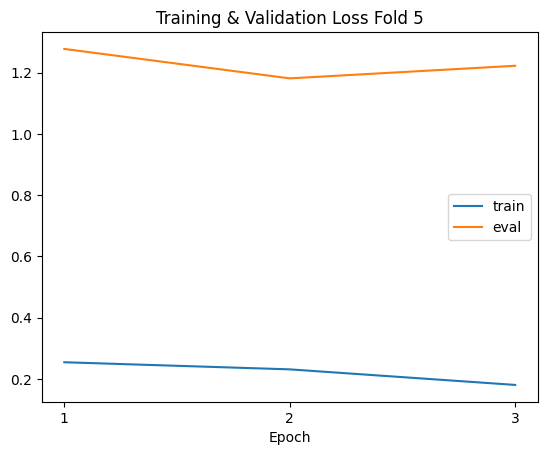

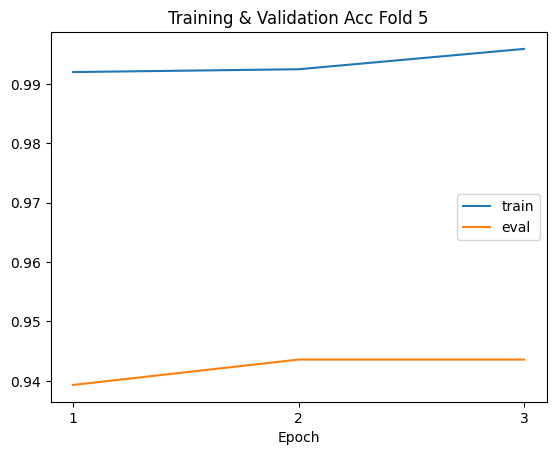

TEST LOSS:0.2145 ACC:0.99 F1:0.97 REC:0.97 PRE:0.97: 100%|██████████| 28/28 [00:01<00:00, 16.13it/s]


(Epoch 3) TEST LOSS:0.2145 ACC:0.99 F1:0.97 REC:0.97 PRE:0.97


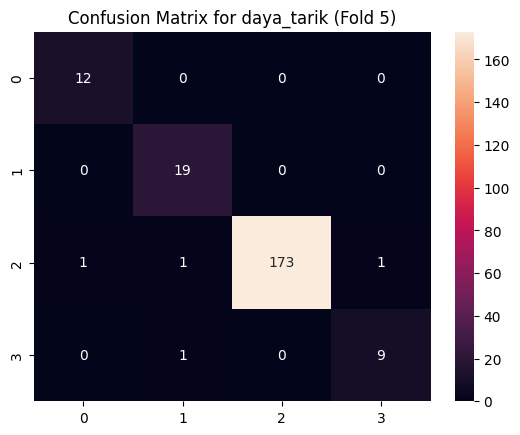

              precision    recall  f1-score   support

     negatif       0.92      1.00      0.96        12
      netral       0.90      1.00      0.95        19
        none       1.00      0.98      0.99       176
     positif       0.90      0.90      0.90        10

    accuracy                           0.98       217
   macro avg       0.93      0.97      0.95       217
weighted avg       0.98      0.98      0.98       217



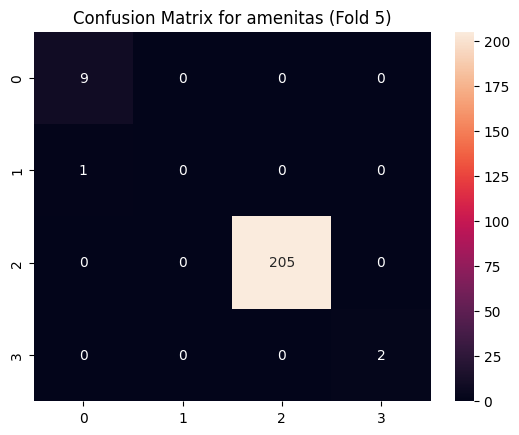

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     negatif       0.90      1.00      0.95         9
      netral       0.00      0.00      0.00         1
        none       1.00      1.00      1.00       205
     positif       1.00      1.00      1.00         2

    accuracy                           1.00       217
   macro avg       0.72      0.75      0.74       217
weighted avg       0.99      1.00      0.99       217



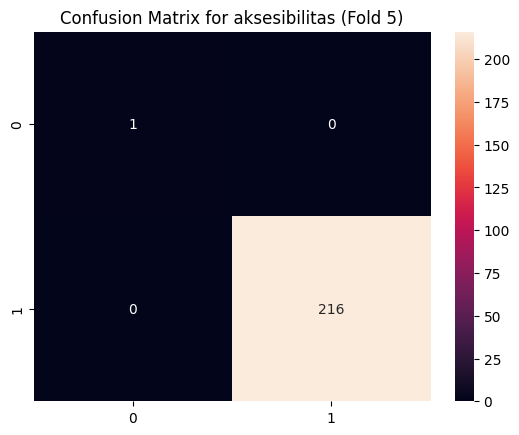

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00         1
        none       1.00      1.00      1.00       216

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217



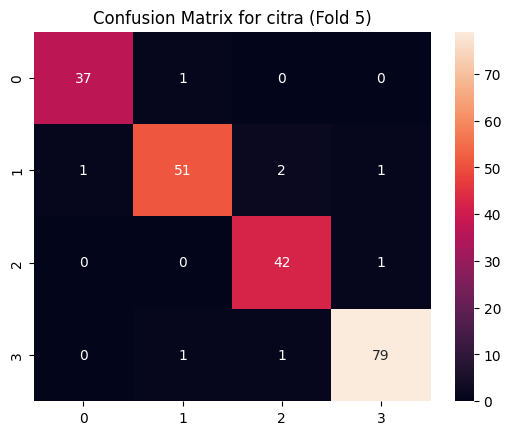

              precision    recall  f1-score   support

     negatif       0.97      0.97      0.97        38
      netral       0.96      0.93      0.94        55
        none       0.93      0.98      0.95        43
     positif       0.98      0.98      0.98        81

    accuracy                           0.96       217
   macro avg       0.96      0.96      0.96       217
weighted avg       0.96      0.96      0.96       217



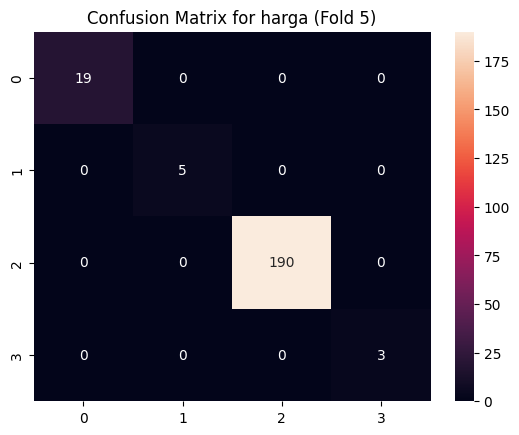

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00        19
      netral       1.00      1.00      1.00         5
        none       1.00      1.00      1.00       190
     positif       1.00      1.00      1.00         3

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217



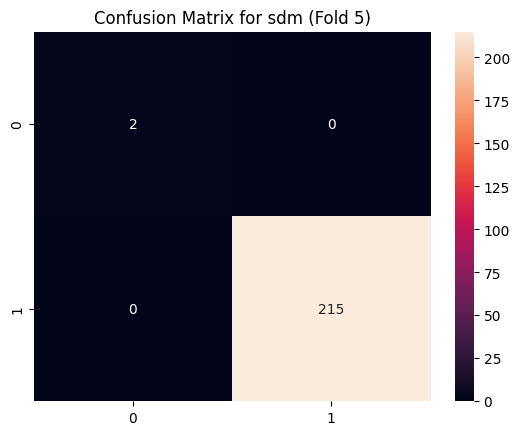

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00         2
        none       1.00      1.00      1.00       215

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217

Iteration time for fold 5: 83.58 seconds
Accuracy for fold 5: [0.982, 0.995, 1.0, 0.963, 1.0, 1.0]
F1 Score for fold 5: [0.982, 0.993, 1.0, 0.963, 1.0, 1.0]


(Epoch 1) TRAIN LOSS:0.2618 LR:0.00001000: 100%|██████████| 220/220 [00:22<00:00,  9.73it/s]


(Epoch 1) TRAIN LOSS:0.2618 ACC:0.99 F1:0.98 REC:0.97 PRE:0.98 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 32.82it/s]


(Epoch 1) VALID LOSS: 0.7020 ACC:0.97 F1:0.92 REC:0.92 PRE:0.92


(Epoch 2) TRAIN LOSS:0.1963 LR:0.00001000: 100%|██████████| 220/220 [00:23<00:00,  9.46it/s]


(Epoch 2) TRAIN LOSS:0.1963 ACC:0.99 F1:0.99 REC:0.98 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 32.67it/s]


(Epoch 2) VALID LOSS: 0.6705 ACC:0.97 F1:0.92 REC:0.91 PRE:0.92


(Epoch 3) TRAIN LOSS:0.1488 LR:0.00001000: 100%|██████████| 220/220 [00:23<00:00,  9.35it/s]


(Epoch 3) TRAIN LOSS:0.1488 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 29.12it/s]


(Epoch 3) VALID LOSS: 0.6448 ACC:0.97 F1:0.92 REC:0.92 PRE:0.93


(Epoch 4) TRAIN LOSS:0.1258 LR:0.00001000: 100%|██████████| 220/220 [00:23<00:00,  9.44it/s]


(Epoch 4) TRAIN LOSS:0.1258 ACC:1.00 F1:0.99 REC:0.99 PRE:1.00 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 37.65it/s]


(Epoch 4) VALID LOSS: 0.7191 ACC:0.97 F1:0.91 REC:0.91 PRE:0.91
Early stopping at epoch 4, loading best model from epoch 3


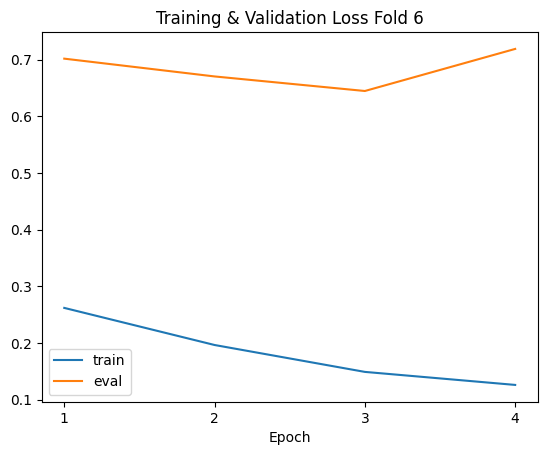

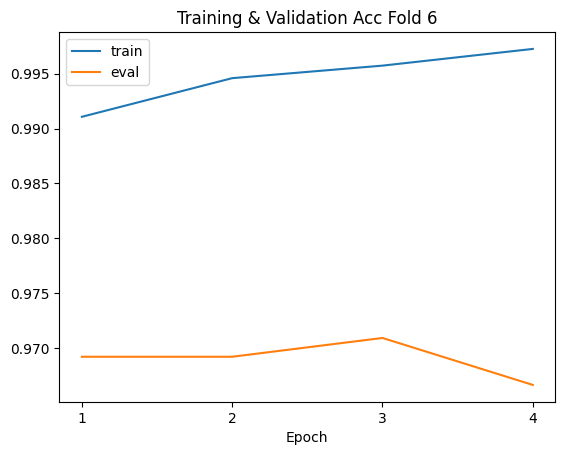

TEST LOSS:0.0438 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00:   4%|▎         | 1/27 [00:00<00:05,  4.98it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
TEST LOSS:0.3988 ACC:0.99 F1:0.74 REC:0.74 PRE:0.75:   4%|▎         | 1/27 [00:00<00:05,  4.98it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
TEST LOSS:0.3534 ACC:0.98 F1:0.95 REC:0.95 PRE:0.96: 100%|██████████| 27/27 [00:01<00:00, 14.94it/s]


(Epoch 4) TEST LOSS:0.3534 ACC:0.98 F1:0.95 REC:0.95 PRE:0.96


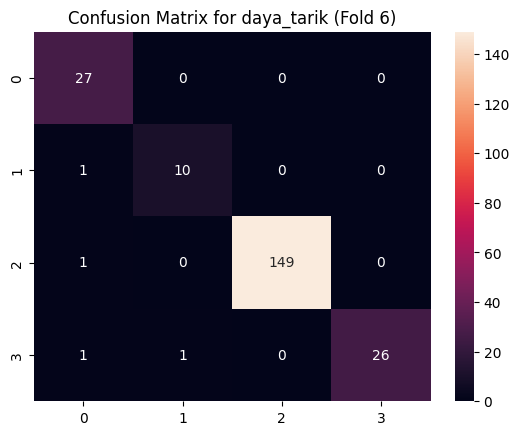

              precision    recall  f1-score   support

     negatif       0.90      1.00      0.95        27
      netral       0.91      0.91      0.91        11
        none       1.00      0.99      1.00       150
     positif       1.00      0.93      0.96        28

    accuracy                           0.98       216
   macro avg       0.95      0.96      0.95       216
weighted avg       0.98      0.98      0.98       216



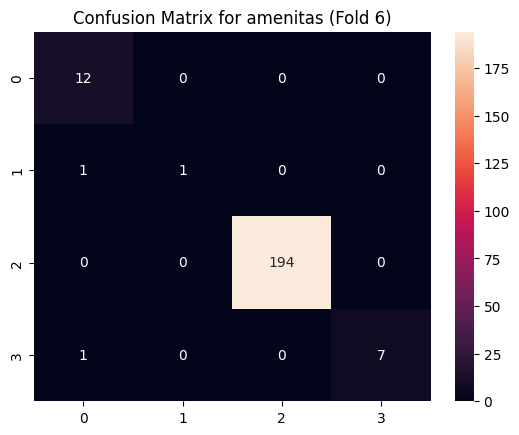

              precision    recall  f1-score   support

     negatif       0.86      1.00      0.92        12
      netral       1.00      0.50      0.67         2
        none       1.00      1.00      1.00       194
     positif       1.00      0.88      0.93         8

    accuracy                           0.99       216
   macro avg       0.96      0.84      0.88       216
weighted avg       0.99      0.99      0.99       216



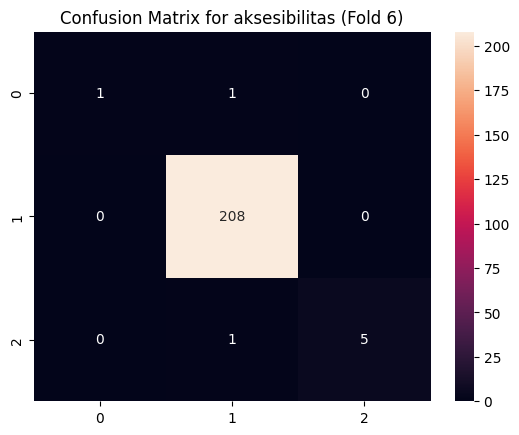

              precision    recall  f1-score   support

      netral       1.00      0.50      0.67         2
        none       0.99      1.00      1.00       208
     positif       1.00      0.83      0.91         6

    accuracy                           0.99       216
   macro avg       1.00      0.78      0.86       216
weighted avg       0.99      0.99      0.99       216



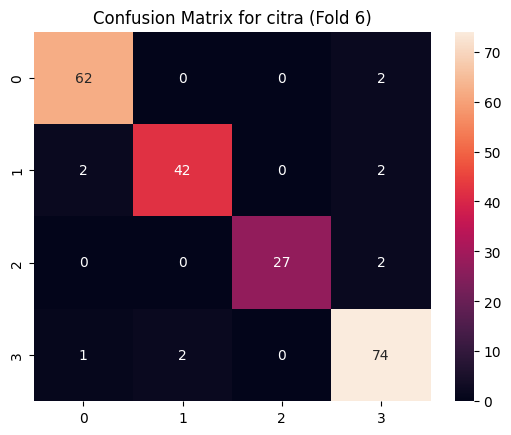

              precision    recall  f1-score   support

     negatif       0.95      0.97      0.96        64
      netral       0.95      0.91      0.93        46
        none       1.00      0.93      0.96        29
     positif       0.93      0.96      0.94        77

    accuracy                           0.95       216
   macro avg       0.96      0.94      0.95       216
weighted avg       0.95      0.95      0.95       216



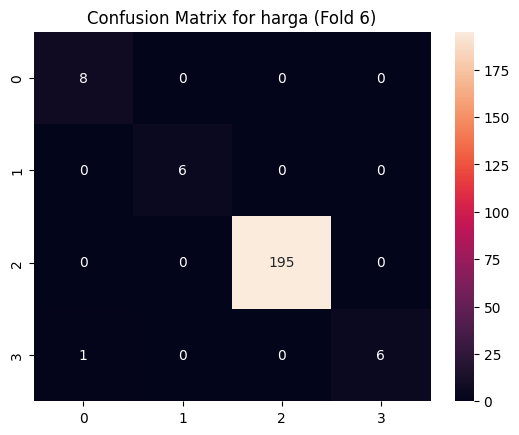

              precision    recall  f1-score   support

     negatif       0.89      1.00      0.94         8
      netral       1.00      1.00      1.00         6
        none       1.00      1.00      1.00       195
     positif       1.00      0.86      0.92         7

    accuracy                           1.00       216
   macro avg       0.97      0.96      0.97       216
weighted avg       1.00      1.00      1.00       216



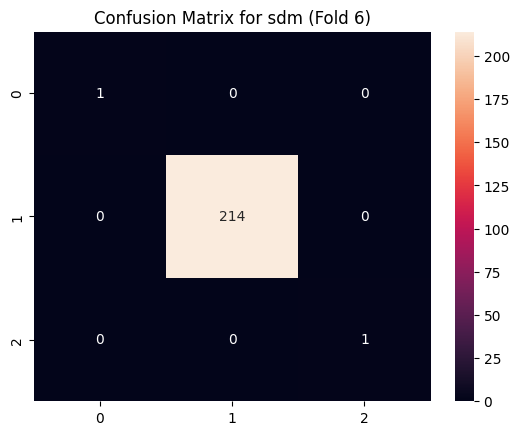

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00         1
        none       1.00      1.00      1.00       214
     positif       1.00      1.00      1.00         1

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216

Iteration time for fold 6: 114.62 seconds
Accuracy for fold 6: [0.981, 0.991, 0.991, 0.949, 0.995, 1.0]
F1 Score for fold 6: [0.982, 0.99, 0.99, 0.949, 0.995, 1.0]


(Epoch 1) TRAIN LOSS:0.1687 LR:0.00001000: 100%|██████████| 220/220 [00:22<00:00,  9.68it/s]


(Epoch 1) TRAIN LOSS:0.1687 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 35.95it/s]


(Epoch 1) VALID LOSS: 0.5238 ACC:0.97 F1:0.92 REC:0.93 PRE:0.92


(Epoch 2) TRAIN LOSS:0.1329 LR:0.00001000: 100%|██████████| 220/220 [00:24<00:00,  9.02it/s]


(Epoch 2) TRAIN LOSS:0.1329 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:01<00:00, 23.73it/s]


(Epoch 2) VALID LOSS: 0.5327 ACC:0.97 F1:0.92 REC:0.93 PRE:0.92
Early stopping at epoch 2, loading best model from epoch 1


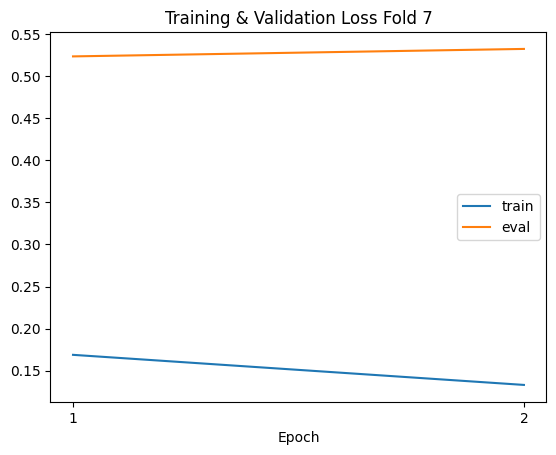

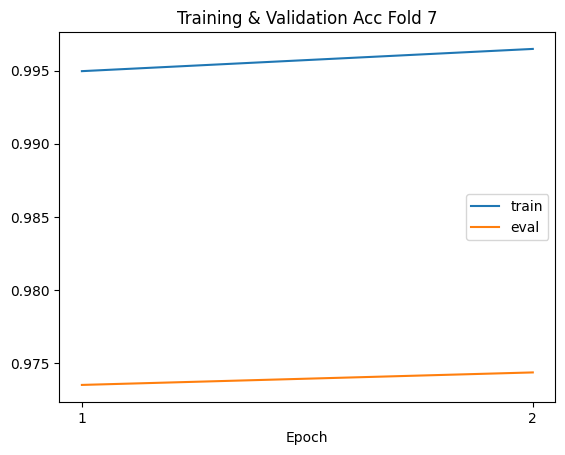

TEST LOSS:0.3092 ACC:0.99 F1:0.98 REC:0.98 PRE:0.99: 100%|██████████| 27/27 [00:01<00:00, 19.85it/s]


(Epoch 2) TEST LOSS:0.3092 ACC:0.99 F1:0.98 REC:0.98 PRE:0.99


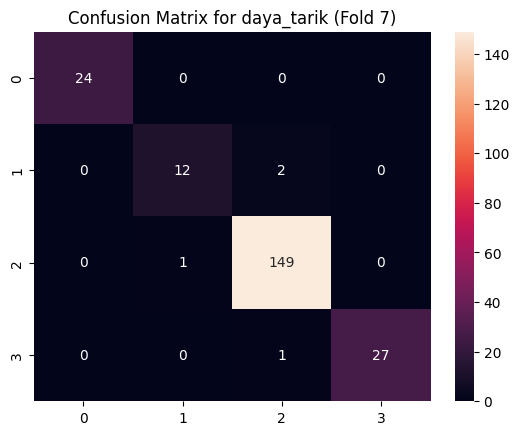

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00        24
      netral       0.92      0.86      0.89        14
        none       0.98      0.99      0.99       150
     positif       1.00      0.96      0.98        28

    accuracy                           0.98       216
   macro avg       0.98      0.95      0.96       216
weighted avg       0.98      0.98      0.98       216



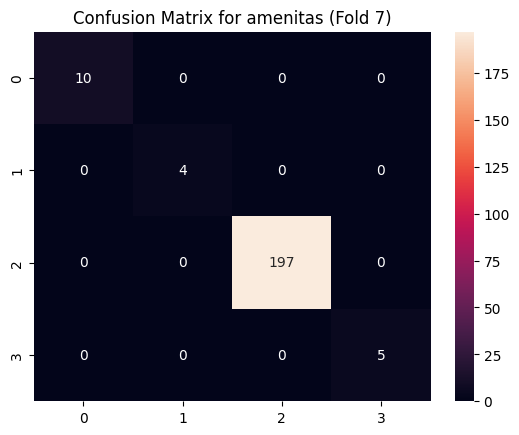

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00        10
      netral       1.00      1.00      1.00         4
        none       1.00      1.00      1.00       197
     positif       1.00      1.00      1.00         5

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



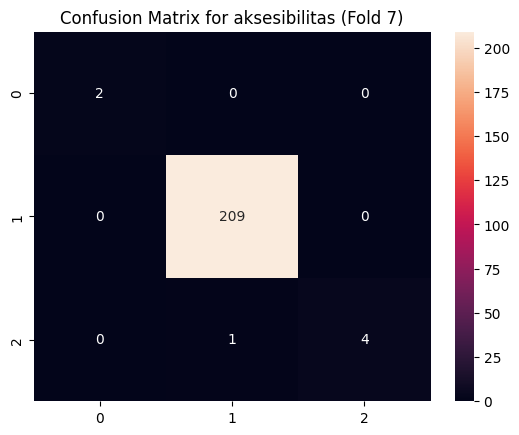

              precision    recall  f1-score   support

      netral       1.00      1.00      1.00         2
        none       1.00      1.00      1.00       209
     positif       1.00      0.80      0.89         5

    accuracy                           1.00       216
   macro avg       1.00      0.93      0.96       216
weighted avg       1.00      1.00      1.00       216



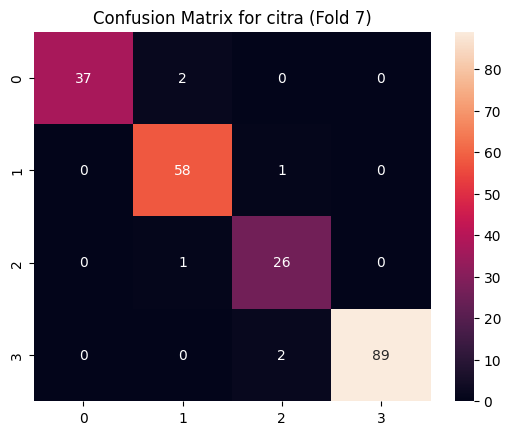

              precision    recall  f1-score   support

     negatif       1.00      0.95      0.97        39
      netral       0.95      0.98      0.97        59
        none       0.90      0.96      0.93        27
     positif       1.00      0.98      0.99        91

    accuracy                           0.97       216
   macro avg       0.96      0.97      0.96       216
weighted avg       0.97      0.97      0.97       216



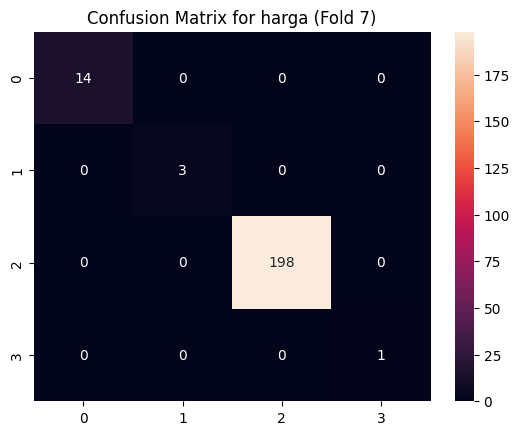

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00        14
      netral       1.00      1.00      1.00         3
        none       1.00      1.00      1.00       198
     positif       1.00      1.00      1.00         1

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



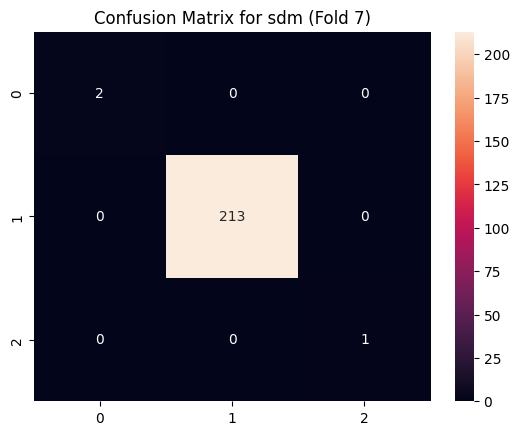

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00         2
        none       1.00      1.00      1.00       213
     positif       1.00      1.00      1.00         1

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216

Iteration time for fold 7: 62.83 seconds
Accuracy for fold 7: [0.981, 1.0, 0.995, 0.972, 1.0, 1.0]
F1 Score for fold 7: [0.981, 1.0, 0.995, 0.973, 1.0, 1.0]


(Epoch 1) TRAIN LOSS:0.1645 LR:0.00001000: 100%|██████████| 220/220 [00:22<00:00,  9.59it/s]


(Epoch 1) TRAIN LOSS:0.1645 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 28.25it/s]


(Epoch 1) VALID LOSS: 0.4287 ACC:0.98 F1:0.94 REC:0.95 PRE:0.93


(Epoch 2) TRAIN LOSS:0.1509 LR:0.00001000: 100%|██████████| 220/220 [00:24<00:00,  8.83it/s]


(Epoch 2) TRAIN LOSS:0.1509 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:01<00:00, 23.50it/s]


(Epoch 2) VALID LOSS: 0.3927 ACC:0.98 F1:0.95 REC:0.96 PRE:0.95


(Epoch 3) TRAIN LOSS:0.1099 LR:0.00001000: 100%|██████████| 220/220 [00:24<00:00,  9.12it/s]


(Epoch 3) TRAIN LOSS:0.1099 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 33.57it/s]


(Epoch 3) VALID LOSS: 0.3657 ACC:0.98 F1:0.95 REC:0.95 PRE:0.95


(Epoch 4) TRAIN LOSS:0.0960 LR:0.00001000: 100%|██████████| 220/220 [00:24<00:00,  9.10it/s]


(Epoch 4) TRAIN LOSS:0.0960 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 37.45it/s]


(Epoch 4) VALID LOSS: 0.3934 ACC:0.98 F1:0.95 REC:0.95 PRE:0.94
Early stopping at epoch 4, loading best model from epoch 3


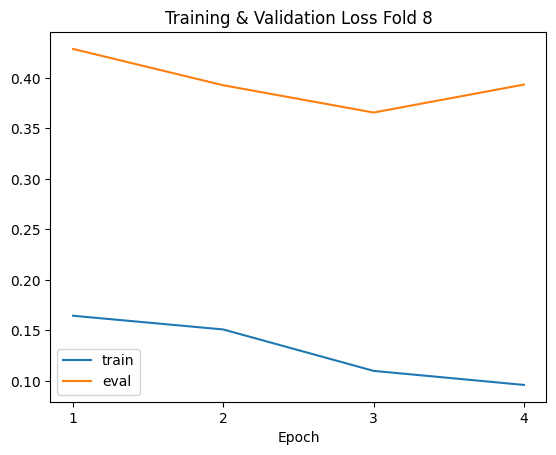

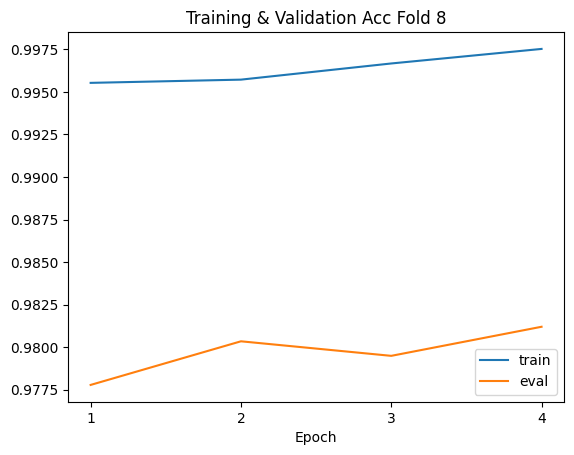

TEST LOSS:0.1864 ACC:0.99 F1:0.98 REC:0.98 PRE:0.98: 100%|██████████| 27/27 [00:01<00:00, 15.91it/s]


(Epoch 4) TEST LOSS:0.1864 ACC:0.99 F1:0.98 REC:0.98 PRE:0.98


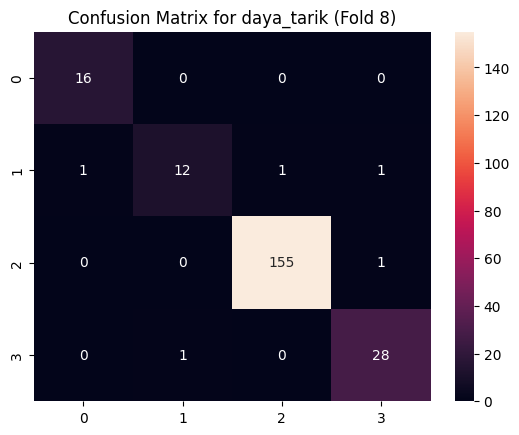

              precision    recall  f1-score   support

     negatif       0.94      1.00      0.97        16
      netral       0.92      0.80      0.86        15
        none       0.99      0.99      0.99       156
     positif       0.93      0.97      0.95        29

    accuracy                           0.98       216
   macro avg       0.95      0.94      0.94       216
weighted avg       0.98      0.98      0.98       216



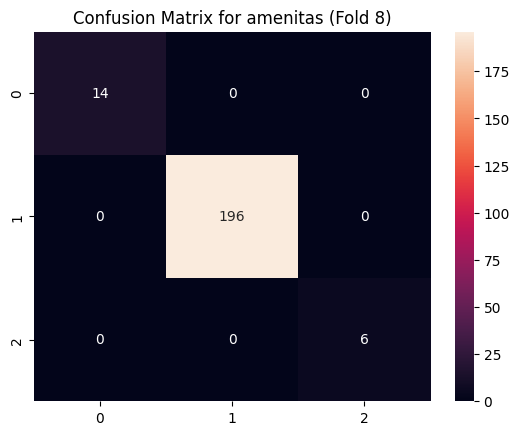

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00        14
        none       1.00      1.00      1.00       196
     positif       1.00      1.00      1.00         6

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



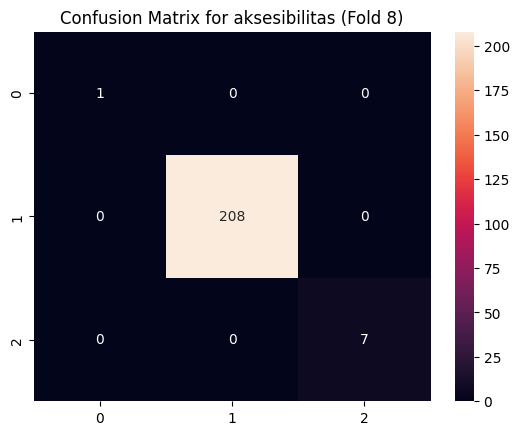

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00         1
        none       1.00      1.00      1.00       208
     positif       1.00      1.00      1.00         7

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



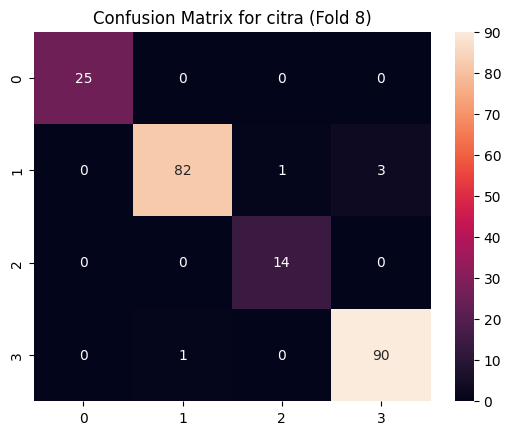

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00        25
      netral       0.99      0.95      0.97        86
        none       0.93      1.00      0.97        14
     positif       0.97      0.99      0.98        91

    accuracy                           0.98       216
   macro avg       0.97      0.99      0.98       216
weighted avg       0.98      0.98      0.98       216



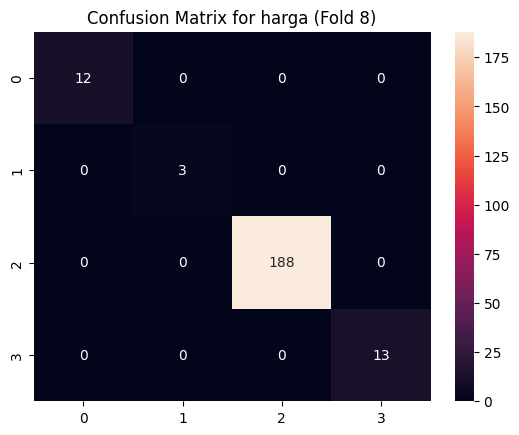

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00        12
      netral       1.00      1.00      1.00         3
        none       1.00      1.00      1.00       188
     positif       1.00      1.00      1.00        13

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



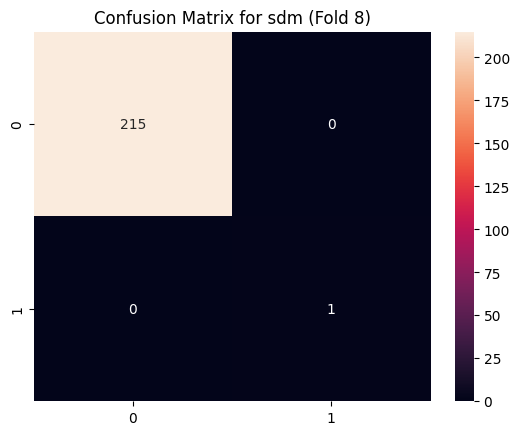

              precision    recall  f1-score   support

        none       1.00      1.00      1.00       215
     positif       1.00      1.00      1.00         1

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216

Iteration time for fold 8: 120.88 seconds
Accuracy for fold 8: [0.977, 1.0, 1.0, 0.977, 1.0, 1.0]
F1 Score for fold 8: [0.976, 1.0, 1.0, 0.977, 1.0, 1.0]


(Epoch 1) TRAIN LOSS:0.1159 LR:0.00001000: 100%|██████████| 220/220 [00:23<00:00,  9.48it/s]


(Epoch 1) TRAIN LOSS:0.1159 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 36.36it/s]


(Epoch 1) VALID LOSS: 0.3800 ACC:0.98 F1:0.95 REC:0.96 PRE:0.95


(Epoch 2) TRAIN LOSS:0.1237 LR:0.00001000: 100%|██████████| 220/220 [00:24<00:00,  8.98it/s]


(Epoch 2) TRAIN LOSS:0.1237 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 25.95it/s]


(Epoch 2) VALID LOSS: 0.3729 ACC:0.98 F1:0.95 REC:0.95 PRE:0.95


(Epoch 3) TRAIN LOSS:0.1123 LR:0.00001000: 100%|██████████| 220/220 [00:24<00:00,  8.92it/s]


(Epoch 3) TRAIN LOSS:0.1123 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 27.63it/s]


(Epoch 3) VALID LOSS: 0.3694 ACC:0.98 F1:0.94 REC:0.94 PRE:0.94


(Epoch 4) TRAIN LOSS:0.0875 LR:0.00001000: 100%|██████████| 220/220 [00:24<00:00,  9.12it/s]


(Epoch 4) TRAIN LOSS:0.0875 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 29.79it/s]


(Epoch 4) VALID LOSS: 0.3645 ACC:0.98 F1:0.95 REC:0.95 PRE:0.94


(Epoch 5) TRAIN LOSS:0.0702 LR:0.00001000: 100%|██████████| 220/220 [00:25<00:00,  8.49it/s]


(Epoch 5) TRAIN LOSS:0.0702 ACC:1.00 F1:1.00 REC:0.99 PRE:1.00 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 28.14it/s]


(Epoch 5) VALID LOSS: 0.3563 ACC:0.98 F1:0.95 REC:0.95 PRE:0.95


(Epoch 6) TRAIN LOSS:0.0634 LR:0.00001000: 100%|██████████| 220/220 [00:24<00:00,  8.96it/s]


(Epoch 6) TRAIN LOSS:0.0634 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 36.99it/s]


(Epoch 6) VALID LOSS: 0.3757 ACC:0.98 F1:0.95 REC:0.96 PRE:0.94
Early stopping at epoch 6, loading best model from epoch 5


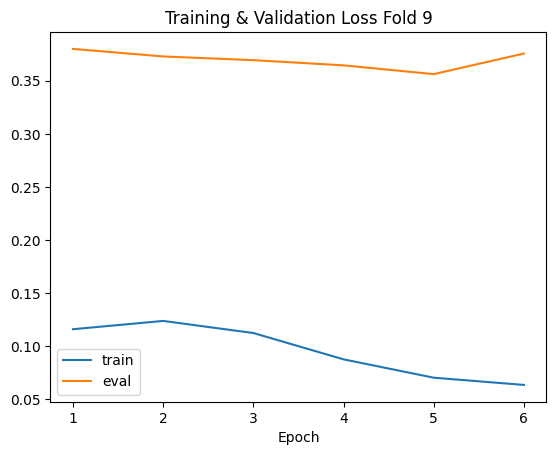

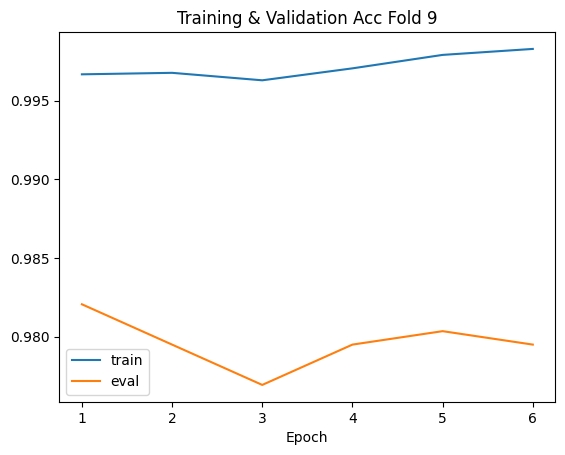

TEST LOSS:0.0995 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99: 100%|██████████| 27/27 [00:01<00:00, 14.31it/s]


(Epoch 6) TEST LOSS:0.0995 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99


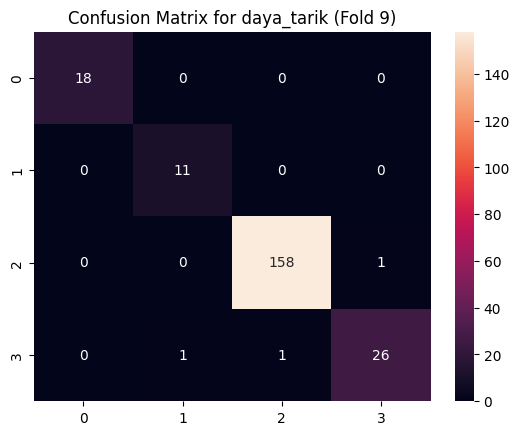

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00        18
      netral       0.92      1.00      0.96        11
        none       0.99      0.99      0.99       159
     positif       0.96      0.93      0.95        28

    accuracy                           0.99       216
   macro avg       0.97      0.98      0.97       216
weighted avg       0.99      0.99      0.99       216



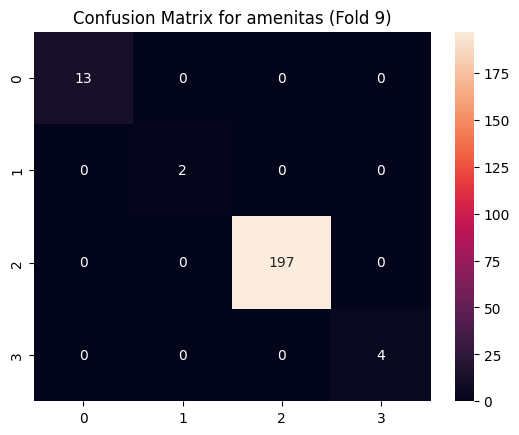

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00        13
      netral       1.00      1.00      1.00         2
        none       1.00      1.00      1.00       197
     positif       1.00      1.00      1.00         4

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



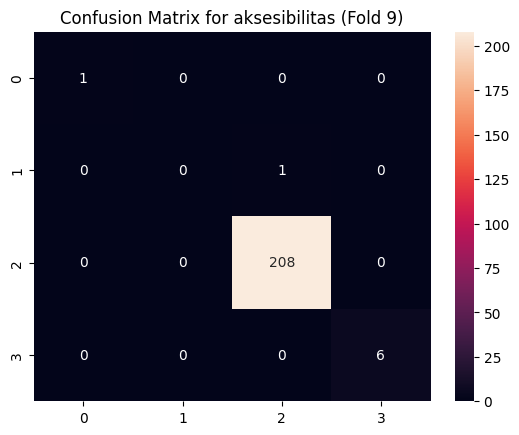

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00         1
      netral       0.00      0.00      0.00         1
        none       1.00      1.00      1.00       208
     positif       1.00      1.00      1.00         6

    accuracy                           1.00       216
   macro avg       0.75      0.75      0.75       216
weighted avg       0.99      1.00      0.99       216



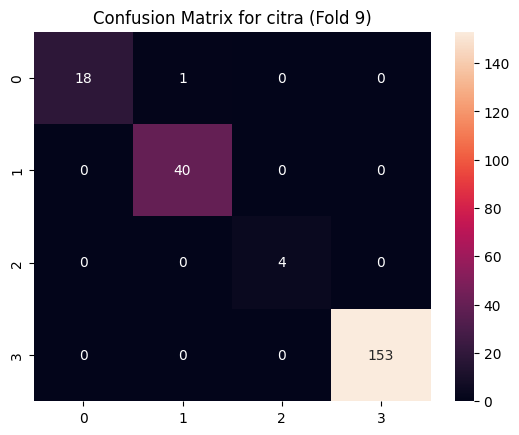

              precision    recall  f1-score   support

     negatif       1.00      0.95      0.97        19
      netral       0.98      1.00      0.99        40
        none       1.00      1.00      1.00         4
     positif       1.00      1.00      1.00       153

    accuracy                           1.00       216
   macro avg       0.99      0.99      0.99       216
weighted avg       1.00      1.00      1.00       216



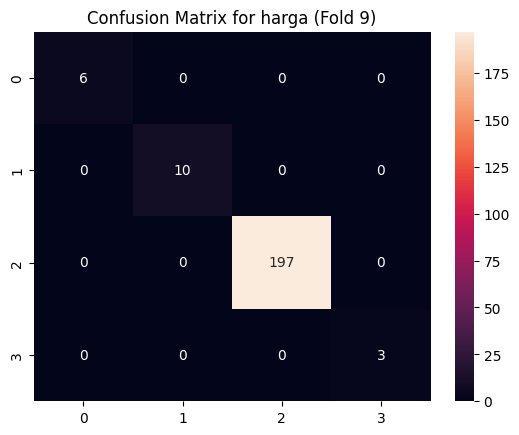

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00         6
      netral       1.00      1.00      1.00        10
        none       1.00      1.00      1.00       197
     positif       1.00      1.00      1.00         3

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



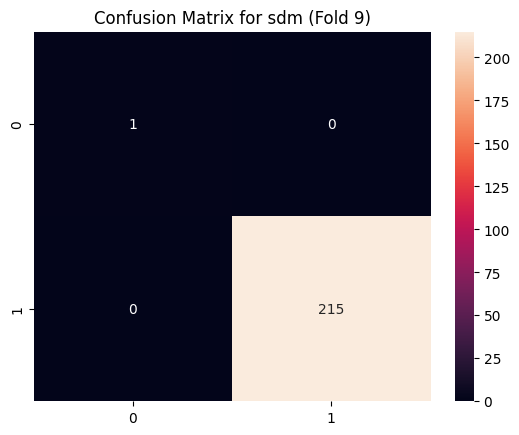

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00         1
        none       1.00      1.00      1.00       215

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216

Iteration time for fold 9: 190.22 seconds
Accuracy for fold 9: [0.986, 1.0, 0.995, 0.995, 1.0, 1.0]
F1 Score for fold 9: [0.986, 1.0, 0.993, 0.995, 1.0, 1.0]


(Epoch 1) TRAIN LOSS:0.0838 LR:0.00001000: 100%|██████████| 220/220 [00:22<00:00,  9.64it/s]


(Epoch 1) TRAIN LOSS:0.0838 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 40.92it/s]


(Epoch 1) VALID LOSS: 0.2425 ACC:0.99 F1:0.96 REC:0.97 PRE:0.96


(Epoch 2) TRAIN LOSS:0.0767 LR:0.00001000: 100%|██████████| 220/220 [00:24<00:00,  8.89it/s]


(Epoch 2) TRAIN LOSS:0.0767 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 31.40it/s]


(Epoch 2) VALID LOSS: 0.2229 ACC:0.99 F1:0.97 REC:0.98 PRE:0.96


(Epoch 3) TRAIN LOSS:0.0789 LR:0.00001000: 100%|██████████| 220/220 [00:24<00:00,  8.92it/s]


(Epoch 3) TRAIN LOSS:0.0789 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00001000


100%|██████████| 25/25 [00:00<00:00, 39.80it/s]


(Epoch 3) VALID LOSS: 0.2357 ACC:0.99 F1:0.96 REC:0.97 PRE:0.96
Early stopping at epoch 3, loading best model from epoch 2


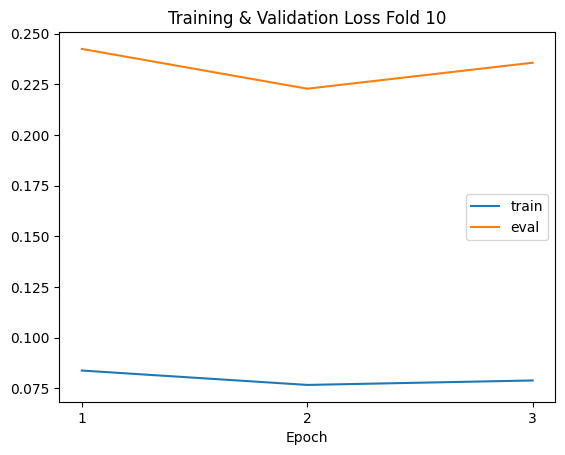

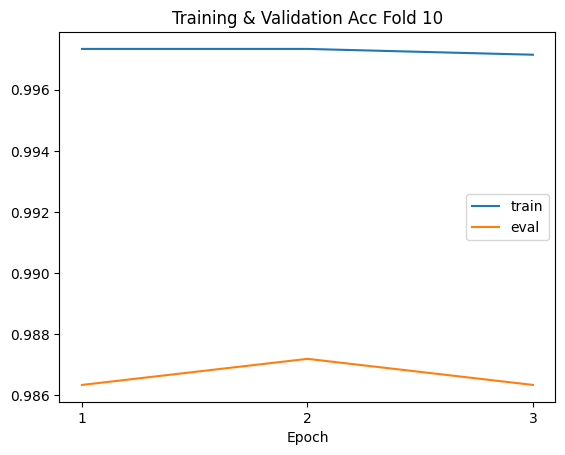

TEST LOSS:0.3119 ACC:0.99 F1:0.97 REC:0.97 PRE:0.98: 100%|██████████| 27/27 [00:01<00:00, 16.86it/s]


(Epoch 3) TEST LOSS:0.3119 ACC:0.99 F1:0.97 REC:0.97 PRE:0.98


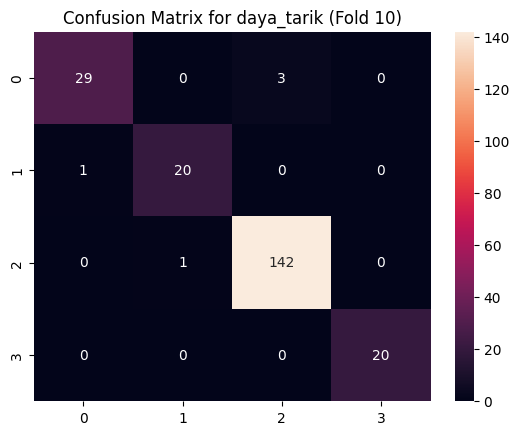

              precision    recall  f1-score   support

     negatif       0.97      0.91      0.94        32
      netral       0.95      0.95      0.95        21
        none       0.98      0.99      0.99       143
     positif       1.00      1.00      1.00        20

    accuracy                           0.98       216
   macro avg       0.97      0.96      0.97       216
weighted avg       0.98      0.98      0.98       216



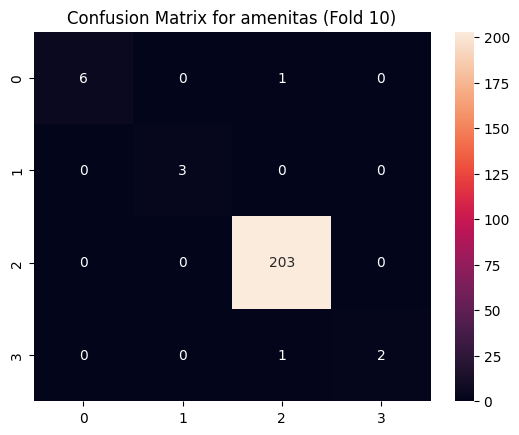

              precision    recall  f1-score   support

     negatif       1.00      0.86      0.92         7
      netral       1.00      1.00      1.00         3
        none       0.99      1.00      1.00       203
     positif       1.00      0.67      0.80         3

    accuracy                           0.99       216
   macro avg       1.00      0.88      0.93       216
weighted avg       0.99      0.99      0.99       216



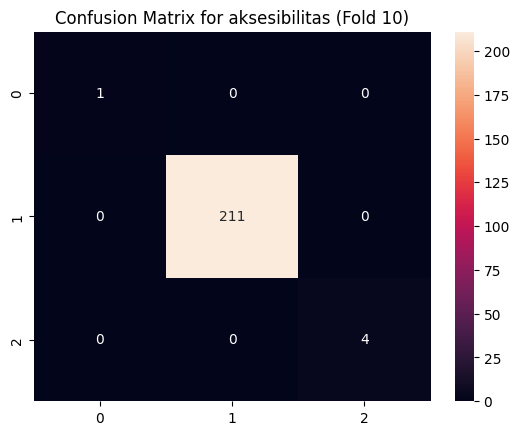

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00         1
        none       1.00      1.00      1.00       211
     positif       1.00      1.00      1.00         4

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



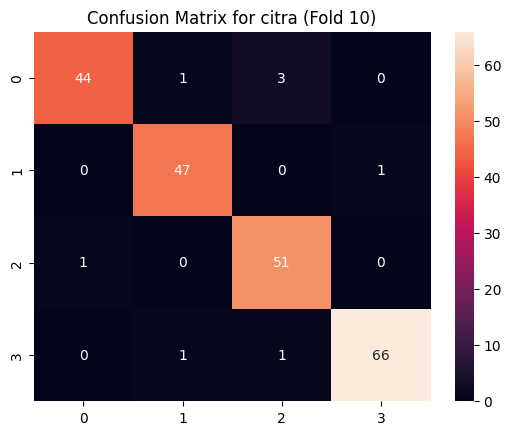

              precision    recall  f1-score   support

     negatif       0.98      0.92      0.95        48
      netral       0.96      0.98      0.97        48
        none       0.93      0.98      0.95        52
     positif       0.99      0.97      0.98        68

    accuracy                           0.96       216
   macro avg       0.96      0.96      0.96       216
weighted avg       0.96      0.96      0.96       216



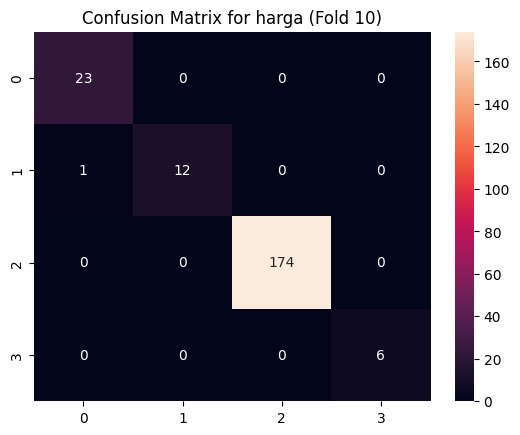

              precision    recall  f1-score   support

     negatif       0.96      1.00      0.98        23
      netral       1.00      0.92      0.96        13
        none       1.00      1.00      1.00       174
     positif       1.00      1.00      1.00         6

    accuracy                           1.00       216
   macro avg       0.99      0.98      0.98       216
weighted avg       1.00      1.00      1.00       216



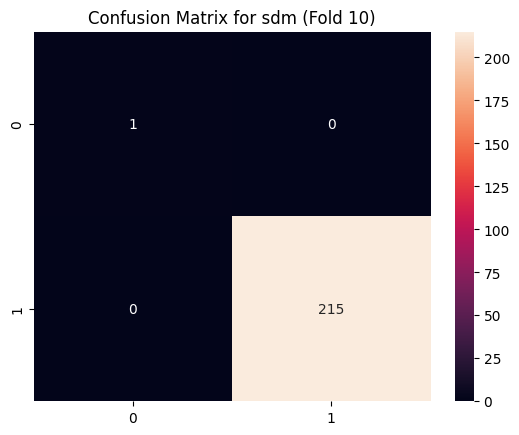

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00         1
        none       1.00      1.00      1.00       215

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216

Iteration time for fold 10: 88.83 seconds
Accuracy for fold 10: [0.977, 0.991, 1.0, 0.963, 0.995, 1.0]
F1 Score for fold 10: [0.977, 0.99, 1.0, 0.963, 0.995, 1.0]
Final Average Accuracy:  [0.958, 0.991, 0.994, 0.945, 0.989, 0.994]
Final Average F1 Score:  [0.957, 0.99, 0.992, 0.944, 0.99, 0.992]


In [ ]:
# Define aspects
aspects = ['daya_tarik', 'amenitas', 'aksesibilitas', 'citra', 'harga', 'sdm']

# Initialize KFold cross-validation
n_fold = 10
kf = KFold(n_splits=n_fold)

# Initialize performance metrics
total_acc = np.zeros(len(aspects))
total_f1 = np.zeros(len(aspects))

for fold_idx, (train_index, test_index) in enumerate(kf.split(X), start=1):
    start_time = time.time()

    # Early stopping parameters
    patience = 1  # Stop after one epoch of no improvement
    best_loss = float('inf')
    epochs_no_improve = 0
    best_epoch = 0

    # Split data train/valid/test
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    # Create datasets
    train_dataset = AspectBasedSentimentAnalysisDataset(X_train, y_train, tokenizer, lowercase=True)
    valid_dataset = AspectBasedSentimentAnalysisDataset(X_valid, y_valid, tokenizer, lowercase=True)
    test_dataset = AspectBasedSentimentAnalysisDataset(X_test, y_test, tokenizer, lowercase=True)

    # Create data loaders
    train_loader = AspectBasedSentimentAnalysisDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=8, num_workers=2, shuffle=True)
    valid_loader = AspectBasedSentimentAnalysisDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=8, num_workers=2, shuffle=False)
    test_loader = AspectBasedSentimentAnalysisDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=8, num_workers=2, shuffle=False)

    fold_acc = []
    fold_f1 = []
    train_loss_lists = []
    train_acc_lists = []
    eval_loss_lists = []
    eval_acc_lists = []

    # Define the path to save the model in Google Drive
    model_save_path = '/content/drive/MyDrive/Skripsi/Library/indobert-s1.pt'

    # Train
    n_epochs = 15  # Start with a high number, early stopping will stop training earlier
    for epoch in range(n_epochs):
        model.train()
        torch.set_grad_enabled(True)

        total_train_loss = 0
        list_hyp, list_label = [], []

        train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
        for i, batch_data in enumerate(train_pbar):
            # Forward model
            loss, batch_hyp, batch_label = forward_sequence_multi_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

            # Update model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_loss = loss.item()
            total_train_loss = total_train_loss + tr_loss

            # Calculate metrics
            list_hyp += batch_hyp
            list_label += batch_label

            train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1), total_train_loss/(i+1), get_lr(optimizer)))

        # Calculate train metric
        metrics = absa_metrics_fn(list_hyp, list_label)
        print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1), total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
        train_acc_lists.append(metrics['ACC'])
        current_train_loss = round(total_train_loss/(i+1), 4)
        train_loss_lists.append(current_train_loss)

        # Evaluate on valid
        model.eval()
        torch.set_grad_enabled(False)

        total_loss, total_correct, total_labels = 0, 0, 0
        list_hyp, list_label = [], []

        valid_pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
        for i, batch_data in enumerate(valid_pbar):
            loss, batch_hyp, batch_label = forward_sequence_multi_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

            # Calculate total loss
            total_loss += loss.item()

            # Calculate evaluation metrics
            list_hyp += batch_hyp
            list_label += batch_label

        # Calculate final metrics for the epoch
        metrics = absa_metrics_fn(list_hyp, list_label)
        current_eval_loss = total_loss / len(valid_loader)
        eval_loss_lists.append(current_eval_loss)
        eval_acc_lists.append(metrics['ACC'])

        print(f"(Epoch {epoch + 1}) VALID LOSS: {current_eval_loss:.4f} {metrics_to_string(metrics)}")

        # Early stopping
        if current_eval_loss < best_loss:
            best_loss = current_eval_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_save_path)
            best_epoch = epoch + 1  # Save the best epoch number
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}, loading best model from epoch {best_epoch}")
                model.load_state_dict(torch.load(model_save_path))
                break

    # LOSS
    plt.plot(train_loss_lists, label='train')
    plt.plot(eval_loss_lists, label='eval')
    plt.xlabel('Epoch')
    plt.title(f'Training & Validation Loss Fold {fold_idx}')
    plt.xticks(np.arange(len(train_loss_lists)), np.arange(1, len(eval_loss_lists)+1))
    plt.legend()
    plt.show()

    # ACC
    plt.plot(train_acc_lists, label='train')
    plt.plot(eval_acc_lists, label='eval')
    plt.xlabel('Epoch')
    plt.title(f'Training & Validation Acc Fold {fold_idx}')
    plt.xticks(np.arange(len(train_acc_lists)), np.arange(1, len(eval_acc_lists)+1))
    plt.legend()
    plt.show()

    # Evaluate on test
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    test_pbar = tqdm(test_loader, leave=True, total=len(test_loader))
    for i, batch_data in enumerate(test_pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_multi_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        test_loss = loss.item()
        total_loss = total_loss + test_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = absa_metrics_fn(list_hyp, list_label)

        test_pbar.set_description("TEST LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = absa_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TEST LOSS:{:.4f} {}".format((epoch+1), total_loss/(i+1), metrics_to_string(metrics)))

    # Convert list to DataFrame
    label = list_hyp
    test = list_label
    y_pred = pd.DataFrame(label, columns=aspects)
    y_test = pd.DataFrame(test, columns=aspects)

    # Evaluate each aspect
    for i, aspect in enumerate(aspects):
        cm = confusion_matrix(y_test[aspect], y_pred[aspect])
        plot_confusion_matrix(cm, aspect, fold_idx)
        print(classification_report(y_test[aspect], y_pred[aspect], zero_division='warn'))

        # Calculate metrics
        acc = accuracy_score(y_test[aspect], y_pred[aspect])
        f1 = f1_score(y_test[aspect], y_pred[aspect], average='weighted')
        fold_acc.append(acc)
        fold_f1.append(f1)
        total_acc[i] += acc
        total_f1[i] += f1

    # Print iteration time
    print(f"Iteration time for fold {fold_idx}: {time.time() - start_time:.2f} seconds")

    # Print fold metrics
    print(f"Accuracy for fold {fold_idx}: {[round(a, 3) for a in fold_acc]}")
    print(f"F1 Score for fold {fold_idx}: {[round(f, 3) for f in fold_f1]}")

# Calculate and print average metrics
average_acc = total_acc / n_fold
average_f1 = total_f1 / n_fold
print("Final Average Accuracy: ", [round(a, 3) for a in average_acc])
print("Final Average F1 Score: ", [round(f, 3) for f in average_f1])

# Test fine-tuned model on sample sentences

In [ ]:
text = 'Tanggal 20 august 2022 sepi banget, tempatnya lumayan bersih orang-orang yang kerja di sana ramah-ramah tempatnya luas hewannya kurang beragam sih cuman ada ayam kalkun kelinci Bebek Angsa kuda dan domba padahal dulu banyak sekali hewan-hewan lainnya seperti buaya gajah dan sebagainya sekarang gara-gara covid mulai jadi sepi waterparknya nggak buka gara- Gaara covid juga di sana ada kayak Cafe outdoor gitu namanya kayoe pinus kopinya lumayan enak ada mie goreng juga di sana ada Pop Mie Jadi kalau lapar bisa makan di situ pegawai cafenya juga ramah-ramah banget.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
labels = [torch.topk(logit, k=1, dim=-1)[1].squeeze().item() for logit in logits]

print(f'Text: {text}')
for i, label in enumerate(labels):
    print(f'Label `{AspectBasedSentimentAnalysisDataset.ASPECT_DOMAIN[i]}` : {i2w[label]} ({F.softmax(logits[i], dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Tanggal 20 august 2022 sepi banget, tempatnya lumayan bersih orang-orang yang kerja di sana ramah-ramah tempatnya luas hewannya kurang beragam sih cuman ada ayam kalkun kelinci Bebek Angsa kuda dan domba padahal dulu banyak sekali hewan-hewan lainnya seperti buaya gajah dan sebagainya sekarang gara-gara covid mulai jadi sepi waterparknya nggak buka gara- Gaara covid juga di sana ada kayak Cafe outdoor gitu namanya kayoe pinus kopinya lumayan enak ada mie goreng juga di sana ada Pop Mie Jadi kalau lapar bisa makan di situ pegawai cafenya juga ramah-ramah banget.
Label `0` : negatif (69.495%)
Label `1` : positif (77.179%)
Label `2` : none (92.347%)
Label `3` : netral (99.412%)
Label `4` : none (90.060%)
Label `5` : positif (78.349%)
